In [1]:
import glob
from collections import OrderedDict

import ROOT
ROOT.gROOT.SetBatch(True)
from ROOT import TCanvas, TFile, TProfile, TNtuple, TH1F, TH2F, TH1D, TH2D, THStack, TF1
from ROOT import gBenchmark, gRandom, gSystem, Double, gPad, TFitResultPtr, TMath
import root_numpy
import psutil
import pandas
import math
#matplotlib.use('agg')
%matplotlib inline
import matplotlib #as matplot
print(matplotlib.__version__)
#print(matplotlib.path)
import matplotlib.pyplot as plt
from matplotlib import cm as cm
import numpy as np
import time
from datetime import datetime

from sklearn.metrics import roc_curve, auc
import pylab
import sklearn as sk
print(sk.__version__)
from sklearn.model_selection import train_test_split

import tensorflow as tf
print(tf.__version__)
######################
import keras as kr
from keras.models import Sequential
from keras.layers import InputLayer, Input
from keras.layers import Reshape, MaxPooling2D
from keras.layers import Conv2D, Dense, Flatten, Dropout, BatchNormalization
from keras.layers.advanced_activations import LeakyReLU, ELU, PReLU 
from keras.optimizers import Adamax
from keras.optimizers import Nadam
print(kr.__version__)
#from keras import backend as K
import tensorflow as tf
print(tf.__version__)
config = tf.ConfigProto(intra_op_parallelism_threads=32, \
                        inter_op_parallelism_threads=32, \
                        allow_soft_placement=True, \
                        device_count = {'CPU': 32}
                       )
session = tf.Session(config=config)
#K.set_session(session)
## it will issue a warning, just ignore

Welcome to JupyROOT 6.12/07
2.2.3
0.19.1
1.6.0


Using Theano backend.


2.1.4
1.6.0


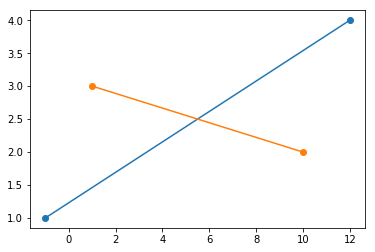

In [2]:
# test that matplotlib imported ok
x1, y1 = [-1, 12], [1, 4]
x2, y2 = [1, 10], [3, 2]
plt.plot(x1, y1, x2, y2, marker = 'o')
plt.show()

In [38]:
def num_to_str(num):
    temp_str = str(num)
    final_str = temp_str.replace('.', 'o')
    return final_str

################
## load the data
################
channel='2l_2tau_HH'
bdtType = "evtLevelSUM_HH_2l_2tau_res"
tauID = "dR03mvaVLoose"

##-------Choose your background gen_mHH randomiz. method ----##
#Bkg_mass_rand="default"
Bkg_mass_rand="oversampling"
##----------------------------------------------------------##

##-------- To include all masses use these --------------##
variables="finalVars_allMasses"
TrainMode=0 
##----------------------------------------------------------##

##-------- To include Low masses (=< 400 GeV) only use these --------------##
#variables="finalVars_LowMasses"
#TrainMode=1 
##----------------------------------------------------------##

##-------- To include High masses (> 400 GeV) only use these --------------##
#variables="finalVars_HighMasses"
#TrainMode=2 
##----------------------------------------------------------##

## --- To reweight Input Variables set this to true ---- ###
do_ReweightVars=True
##----------------------------------------------------------##

## --- Set this to true to get Histograms and THStack plots ---- ###
do_2l_2tau_diagnostics=True
##----------------------------------------------------------##

#weights="totalWeight" ## Was used in the BDT code
#target='target'       ## Was used in the BDT code

startTime = datetime.now()
#run ../python/data_manager.py
execfile("../python/data_manager.py") 

if channel=='2l_2tau_HH' : 
    #run ../cards/info_2l_2tau_HH.py
    execfile("../cards/info_2l_2tau_HH.py") 

log_file_name=channel+".log"
if 'evtLevelSUM_HH_2l_2tau_res' in bdtType:
    file1_ = open(log_file_name, 'w+')
else: 
    file1_ = open('roc.log','w+')    

## ---- Set these values for NN hyper-parameters --- ##
EPOCHS=35
DROPOUT=0.01
LR=0.0005
SCHEDULE_DECAY=0.00005
BATCH_SIZE=256
##----------------------------------------------------------##    

hyppar=str(variables)+"_epochs_"+str(EPOCHS)+"_dropout_"+num_to_str(DROPOUT)+"_lr_"+num_to_str(LR)+"_sch_decay_"+num_to_str(SCHEDULE_DECAY)+"_batch_size_"+str(BATCH_SIZE)
    
print hyppar

import shutil,subprocess
proc=subprocess.Popen(['mkdir '+channel],shell=True,stdout=subprocess.PIPE)
out = proc.stdout.read()    
    
    
output = read_from(Bkg_mass_rand, tauID)

finalVars_allMasses_epochs_35_dropout_0o01_lr_0o0005_sch_decay_5e-05_batch_size_256


mkdir: cannot create directory `2l_2tau_HH': File exists


In [4]:
def numpyarrayTProfileFill(data_X, data_Y, data_wt, hprof):
    for x,y,w in np.nditer([data_X, data_Y, data_wt]):
        #print("x: {}, y: {}, w: {}".format(x, y, w))                                                                                                                                                                                                                   
        hprof.Fill(x,y,w)


def numpyarrayHisto1DFill(data_X, data_wt, histo1D):
    #for x,w in np.nditer([data_X, data_wt]):                                                                                                                                                                                                                           
    for x,w in zip(data_X, data_wt):
        #print("x: {},  w: {}".format(x, w))                                                                                                                                                                                                                            
        histo1D.Fill(x,w)


def AddHistToStack(data_copy, var_name,  hstack, nbins, X_min, X_max, FillColor, processName):
    histo1D = TH1D( 'histo1D', processName, nbins, X_min, X_max)
    data_X_array  = np.array(data_copy[var_name].values, dtype=np.float)
    data_wt_array = np.array(data_copy['totalWeight'].values, dtype=np.float)
    numpyarrayHisto1DFill(data_X_array, data_wt_array, histo1D)
    histo1D.SetFillColor(FillColor)
    #histo1D.Draw()                                                                                                                                                                                                                                                     
    hstack.Add(histo1D)


def BuildTHstack_2l_2tau(hstack, data_copy, var_name, nbins, X_min, X_max):
    ttbar_samples = ['TTTo2L2Nu','TTToSemiLeptonic']
    vv_samples = ['ZZ', 'WZ', 'WW']
    ttv_samples = ['TTZJets', 'TTWJets']
    data_copy_TT  =  data_copy.loc[(data_copy['key'].isin(ttbar_samples))] ## TTbar                                                                                                                                                                                     
    data_copy_DY  =  data_copy.loc[(data_copy['key']=='DY')] ## DY                                                                                                                                                                                                      
    data_copy_VV  =  data_copy.loc[(data_copy['key'].isin(vv_samples))] ## VV                                                                                                                                                                                           
    data_copy_TTV =  data_copy.loc[(data_copy['key'].isin(ttv_samples))] ## TTV                                                                                                                                                                                         
    data_copy_TTH =  data_copy.loc[(data_copy['key']=='TTH')] ## TTH                                                                                                                                                                                                    
    data_copy_VH  =  data_copy.loc[(data_copy['key']=='VH')] ## VH                                                                                                                                                                                                      

    if(data_copy_TTH.empty != True): AddHistToStack(data_copy_TTH, var_name, hstack, nbins, X_min, X_max, 5, 'TTH') ## Yellow                                                                                                                                           
    if(data_copy_TTV.empty != True): AddHistToStack(data_copy_TTV, var_name, hstack, nbins, X_min, X_max, 1, 'TTV')  ## Black                                                                                                                                           
    if(data_copy_VH.empty != True): AddHistToStack(data_copy_VH, var_name, hstack, nbins, X_min, X_max, 6, 'VH')  ## Magenta                                                                                                                                            
    if(data_copy_VV.empty != True): AddHistToStack(data_copy_VV, var_name, hstack, nbins, X_min, X_max, 3, 'VV')    ## Green                                                                                                                                            
    if(data_copy_DY.empty != True): AddHistToStack(data_copy_DY, var_name, hstack, nbins, X_min, X_max, 2, 'DY')      ## Red                                                                                                                                            
    if(data_copy_TT.empty != True): AddHistToStack(data_copy_TT, var_name, hstack, nbins, X_min, X_max, 4, 'TTbar')  ## Blue                                                                                                                                            

def MakeTHStack_New(channel, data, var_name_list, label):
    data_copy = data.copy(deep=True) ## Making a deep copy of data ( => separate data and index from data)                                                                                                                                                              
    data_copy =  data_copy.loc[(data_copy['target']==0)] ## Only take backgrounds                                                                                                                                                                                         

    Histo_Dict = {
        "gen_mHH": {'X_min': 0., 'X_max': 1100., 'nbins': 55},
        "diHiggsMass": {'X_min': 0., 'X_max': 1100., 'nbins': 55},
        "diHiggsVisMass": {'X_min': 0., 'X_max': 1100., 'nbins': 55},
        "met": {'X_min': 0., 'X_max': 1100., 'nbins': 55},
        "mht": {'X_min': 0., 'X_max': 1100., 'nbins': 55},
        "met_LD": {'X_min': 0., 'X_max': 1100., 'nbins': 55},
        "tau1_pt": {'X_min': 0., 'X_max': 1100., 'nbins': 55},
        "tau2_pt": {'X_min': 0., 'X_max': 1100., 'nbins': 55},
        "mT_lep1": {'X_min': 0., 'X_max': 1100., 'nbins': 55},
        "mT_lep2": {'X_min': 0., 'X_max': 1100., 'nbins': 55},
        "m_ll": {'X_min': 0., 'X_max': 1100., 'nbins': 55},
        "mTauTau": {'X_min': 0., 'X_max': 1100., 'nbins': 55},
        "m_lep1_tau2": {'X_min': 0., 'X_max': 1100., 'nbins': 55},
        "dr_lep_tau_min_SS": {'X_min': 0., 'X_max': 1.0, 'nbins': 10},
        "dr_lep_tau_min_OS": {'X_min': 0., 'X_max': 1.0, 'nbins': 10},
        "dr_taus": {'X_min': 0., 'X_max': 1.0, 'nbins': 10},
        "dr_lep1_tau1_tau2_min": {'X_min': 0., 'X_max': 1.0, 'nbins': 10},
        "dr_lep1_tau1_tau2_max": {'X_min': 0., 'X_max': 1.0, 'nbins': 10},
        "max_tau_eta": {'X_min': 0., 'X_max': 3.0, 'nbins': 30},
        "max_lep_eta": {'X_min': 0., 'X_max': 3.0, 'nbins': 30},
        "nElectron": {'X_min': 0., 'X_max': 3.0, 'nbins': 3},
        "nBJet_medium": {'X_min': 0., 'X_max': 3.0, 'nbins': 3},
        "dr_leps": {'X_min': 0., 'X_max': 1.0, 'nbins': 10},
        "tau1_eta": {'X_min': -3.0, 'X_max': 3.0, 'nbins': 60},
        "deltaEta_lep1_tau1": {'X_min': -5.0, 'X_max': 5.0, 'nbins': 100},
        "deltaEta_lep1_tau2": {'X_min': -5.0, 'X_max': 5.0, 'nbins': 100},
        }
    
    for var_name in var_name_list:
        data_X  = np.array(data_copy[var_name].values, dtype=np.float)
        data_wt = np.array(data_copy['totalWeight'].values, dtype=np.float)

        N_x  = len(data_X)
        N_wt = len(data_wt)

        if(N_x == N_wt):
            # Create a new canvas, and customize it.                                                                                                                                                                                                                    
            c1 = TCanvas( 'c1', 'Dynamic Filling Example', 200, 10, 700, 500)
            #c1.SetFillColor(42)                                                                                                                                                                                                                                        
            #c1.GetFrame().SetFillColor(21)                                                                                                                                                                                                                             
            c1.GetFrame().SetBorderSize(6)
            c1.GetFrame().SetBorderMode(-1)

            #print("N_x: {}, N_wt: {}".format(N_x, N_wt))                                                                                                                                                                                                               
            print("Variable Name: {}".format(var_name))
            PlotTitle = var_name
            hstack  = THStack('hstack', PlotTitle)
            BuildTHstack_2l_2tau(hstack, data_copy, var_name, Histo_Dict[var_name]['nbins'], Histo_Dict[var_name]['X_min'], Histo_Dict[var_name]['X_max'])
            hstack.Draw("hist")
            hstack.GetYaxis().SetTitle("Events")
            hstack.GetXaxis().SetTitle(var_name)
            c1.Modified()
            c1.Update()
            gPad.BuildLegend(0.75,0.75,0.95,0.95,"")
            FileName = "{}/{}_{}_{}.root".format(channel, "THStack", var_name, label)
            c1.SaveAs(FileName)
        else:
            print('Arrays not of same length')
            print("N_x: {}, N_wt: {}".format(N_x, N_wt))

def MakeHisto1D_New(channel, data, var_name_list, label):
    Histo_Dict = {
        "gen_mHH": {'X_min': 0., 'X_max': 1100., 'nbins': 55},
        "diHiggsMass": {'X_min': 0., 'X_max': 1100., 'nbins': 55},
        "diHiggsVisMass": {'X_min': 0., 'X_max': 1100., 'nbins': 55},
        "met": {'X_min': 0., 'X_max': 1100., 'nbins': 55},
        "mht": {'X_min': 0., 'X_max': 1100., 'nbins': 55},
        "met_LD": {'X_min': 0., 'X_max': 1100., 'nbins': 55},
        "tau1_pt": {'X_min': 0., 'X_max': 1100., 'nbins': 55},
        "tau2_pt": {'X_min': 0., 'X_max': 1100., 'nbins': 55},
        "mT_lep1": {'X_min': 0., 'X_max': 1100., 'nbins': 55},
        "mT_lep2": {'X_min': 0., 'X_max': 1100., 'nbins': 55},
        "m_ll": {'X_min': 0., 'X_max': 1100., 'nbins': 55},
        "mTauTau": {'X_min': 0., 'X_max': 1100., 'nbins': 55},
        "m_lep1_tau2": {'X_min': 0., 'X_max': 1100., 'nbins': 55},
        "dr_lep_tau_min_SS": {'X_min': 0., 'X_max': 1.0, 'nbins': 10},
        "dr_lep_tau_min_OS": {'X_min': 0., 'X_max': 1.0, 'nbins': 10},
        "dr_taus": {'X_min': 0., 'X_max': 1.0, 'nbins': 10},
        "dr_lep1_tau1_tau2_min": {'X_min': 0., 'X_max': 1.0, 'nbins': 10},
        "dr_lep1_tau1_tau2_max": {'X_min': 0., 'X_max': 1.0, 'nbins': 10},
        "max_tau_eta": {'X_min': 0., 'X_max': 3.0, 'nbins': 30},
        "max_lep_eta": {'X_min': 0., 'X_max': 3.0, 'nbins': 30},
        "nElectron": {'X_min': 0., 'X_max': 3.0, 'nbins': 3},
        "nBJet_medium": {'X_min': 0., 'X_max': 3.0, 'nbins': 3},
        "dr_leps": {'X_min': 0., 'X_max': 1.0, 'nbins': 10},
        "tau1_eta": {'X_min': -3.0, 'X_max': 3.0, 'nbins': 60},
        "deltaEta_lep1_tau1": {'X_min': -5.0, 'X_max': 5.0, 'nbins': 100},
        "deltaEta_lep1_tau2": {'X_min': -5.0, 'X_max': 5.0, 'nbins': 100},
        }
    
    data_copy = data.copy(deep=True) ## Making a deep copy of data ( => separate data and index from data)                                                                                                                                                              
    data_copy =  data_copy.loc[(data_copy['target']==0)] ## Only take backgrounds                                                                                                                                                                                         

    for var_name in var_name_list:
        print("Variable Name: {}".format(var_name))
        data_X  = np.array(data_copy[var_name].values, dtype=np.float)
        data_wt = np.array(data_copy['totalWeight'].values, dtype=np.float)

        N_x  = len(data_X)
        N_wt = len(data_wt)

        # Create a new canvas, and customize it.                                                                                                                                                                                                                        
        c1 = TCanvas( 'c1', "Canvas", 200, 10, 700, 500)
        #c1.SetFillColor(42)                                                                                                                                                                                                                                            
        #c1.GetFrame().SetFillColor(21)                                                                                                                                                                                                                                 
        c1.GetFrame().SetBorderSize(6)
        c1.GetFrame().SetBorderMode(-1)

        if(N_x == N_wt):
            #print("N_x: {}, N_wt: {}".format(N_x, N_wt))                                                                                                                                                                                                               
            PlotTitle = var_name
            histo1D  = TH1D( 'histo1D', PlotTitle, Histo_Dict[var_name]['nbins'], Histo_Dict[var_name]['X_min'], Histo_Dict[var_name]['X_max'])
            histo1D.GetYaxis().SetTitle("Events")
            histo1D.GetXaxis().SetTitle(var_name)
            numpyarrayHisto1DFill(data_X, data_wt, histo1D)
            histo1D.Draw()
            c1.Modified()
            c1.Update()
            FileName = "{}/{}_{}_{}.root".format(channel, "Histo1D", var_name, label)
            c1.SaveAs(FileName)
        else:
            print('Arrays not of same length')
            print("N_x: {}, N_wt: {}".format(N_x, N_wt))
           

def MakeTProfile_New(channel, data, var_name_list, Target, doFit, label, TrainMode, mass_list):
    data_copy = data.copy(deep=True) ## Making a deep copy of data ( => separate data and index from data)                                                                                                                                                              
    data_copy =  data_copy.loc[(data_copy['target']==Target)] ## Only take 1 for signal                                                                                                                                                                                   


    # Create a new canvas, and customize it.                                                                                                                                                                                                                            
    c1 = TCanvas( 'c1', 'Dynamic Filling Example', 200, 10, 700, 500)
    #c1.SetFillColor(42)                                                                                                                                                                                                                                                
    #c1.GetFrame().SetFillColor(21)                                                                                                                                                                                                                                     
    c1.GetFrame().SetBorderSize(6)
    c1.GetFrame().SetBorderMode(-1)
    Y_Range_Dict = {
       "diHiggsMass": {'y_min': 0., 'y_max': 1100.},
       "diHiggsVisMass": {'y_min': 0., 'y_max': 1100.},
       "met": {'y_min': 0., 'y_max': 1100.},
       "mht": {'y_min': 0., 'y_max': 1100.},
       "met_LD": {'y_min': 0., 'y_max': 1100.},
       "tau1_pt": {'y_min': 0., 'y_max': 1100.},
       "tau2_pt": {'y_min': 0., 'y_max': 1100.},
       "mT_lep1": {'y_min': 0., 'y_max': 1100.},
       "mT_lep2": {'y_min': 0., 'y_max': 1100.},
       "m_ll": {'y_min': 0., 'y_max': 1100.},
       "mTauTau": {'y_min': 0., 'y_max': 1100.},
       "m_lep1_tau2": {'y_min': 0., 'y_max': 1100.},
       "dr_lep_tau_min_SS": {'y_min': 0., 'y_max': 1.0},
       "dr_lep_tau_min_OS": {'y_min': 0., 'y_max': 1.0},
       "dr_taus": {'y_min': 0., 'y_max': 1.0},
       "dr_lep1_tau1_tau2_min": {'y_min': 0., 'y_max': 1.0},
       "dr_lep1_tau1_tau2_max": {'y_min': 0., 'y_max': 1.0},
       "max_tau_eta": {'y_min': 0., 'y_max': 3.0},
       "max_lep_eta": {'y_min': 0., 'y_max': 3.0},
       "nElectron": {'y_min': 0., 'y_max': 3.0},
       "nBJet_medium": {'y_min': 0., 'y_max': 3.0},
       "dr_leps": {'y_min': 0., 'y_max': 1.0},
       "tau1_eta": {'y_min': -3.0, 'y_max': 3.0},
       "deltaEta_lep1_tau1": {'y_min': -5.0, 'y_max': 5.0},
       "deltaEta_lep1_tau2": {'y_min': -5.0, 'y_max': 5.0},
       }

    for var_name in var_name_list:
        print("Variable Name: {}".format(var_name))
        if(Target == 1):
            FileName = "{}/{}_{}_{}.root".format(channel, "TProfile_signal", var_name, label)
            #TProfileFile = TFile(FileName, "RECREATE")                                                                                                                                                                                                                 
            if(doFit): Fit_Func_FileName = "{}/{}_{}.root".format(channel, "TProfile_signal_fit_func", var_name)
        elif(Target == 0):
            FileName = "{}/{}_{}_{}.root".format(channel, "TProfile", var_name, label)
            #TProfileFile = TFile(FileName, "RECREATE")                                                                                                                                                                                                                 
        else:
            FileName = "{}/{}_{}.root".format(channel, "TProfile", var_name, label)
            #TProfileFile = TFile(FileName, "RECREATE")                                                                                                                                                                                                                 
        #c1.SaveAs(FileName)                                                                                                                                                                                                                                            

        data_X  = np.array(data_copy['gen_mHH'].values, dtype=np.float)
        data_Y  = np.array(data_copy[var_name].values, dtype=np.float)
        data_wt = np.array(data_copy['totalWeight'].values, dtype=np.float)

        N_x  = len(data_X)
        N_y  = len(data_Y)
        N_wt = len(data_wt)
    
    
        if((N_x == N_y) and (N_y == N_wt)):
            #print("N_x: {}, N_y: {}, N_wt: {}".format(N_x, N_y, N_wt))                                                                                                                                                                                                 
            PlotTitle = 'Profile of '+var_name+' vs gen_mHH'
            #hprof  = TProfile( 'hprof', PlotTitle, 17, 250., 1100., y_min, y_max)                                                                                                                                                                                      
            #xbins = array.array('d', [250., 260., 270., 280., 300., 350., 400., 450., 500., 550., 600., 650., 700., 750., 800., 850., 900., 1000.])                                                                                                                    
            hprof  = TProfile( 'hprof', PlotTitle, (len(mass_list) - 1), mass_list[0], (mass_list[(len(mass_list) - 1)] + 100.0), Y_Range_Dict[var_name]['y_min'], Y_Range_Dict[var_name]['y_max'])
            xbins = array.array('d', mass_list)
            hprof.SetBins((len(xbins) - 1), xbins)
            hprof.GetXaxis().SetTitle("gen_mHH (GeV)")
            hprof.GetYaxis().SetTitle(var_name)
            numpyarrayTProfileFill(data_X, data_Y, data_wt, hprof)
            hprof.Draw()
            c1.Modified()
            c1.Update()
            #c1.SaveAs(FileName)    
            
            if(doFit and (Target == 1)): ## do the fit for signal only                                                                                                                                                                                                  
                if(TrainMode == 0): ## All masses used in the training                                                                                                                                                                                                  
                    if(var_name == "diHiggsMass"): f_old = TF1("f_old", "pol6", 250.,1000.)
                    elif(var_name == "tau1_pt"): f_old = TF1("f_old", "pol1", 250.,1000.)
                    elif(var_name == "met_LD"): f_old = TF1("f_old", "pol1", 250.,1000.)
                    elif(var_name == "diHiggsVisMass"): f_old = TF1("f_old", "pol1", 250.,1000.)
                    #elif(var_name == "m_ll"): f_old = TF1("f_old", "pol1", 250.,1000.)   ## Not used as per Xandra's suggestion                                                                                                                                        
                    elif(var_name == "tau2_pt"): f_old = TF1("f_old", "pol4", 250.,1000.)
                    #elif(var_name == "mTauTau"): f_old = TF1("f_old", "pol1", 250.,1000.) ## Not used as per Xandra's suggestion                                                                                                                                       
                    #elif(var_name == "mT_lep1"): f_old = TF1("f_old", "pol3", 250.,1000.) ## Not used as per Xandra's suggestion                                                                                                                                       
                    #elif(var_name == "mT_lep2"): f_old = TF1("f_old", "pol1", 250.,1000.) ## Not used as per Xandra's suggestion                                                                                                                                       
                    #elif(var_name == "mht"): f_old = TF1("f_old", "pol3", 250.,1000.)     ## Not used as per Xandra's suggestion                                                                                                                                       
                    #elif(var_name == "met"): f_old = TF1("f_old", "pol1", 250.,1000.)     ## Not used as per Xandra's suggestion                                                                                                                                       
                    elif(var_name == "dr_lep_tau_min_SS"): f_old = TF1("f_old", "pol6", 250.,1000.)
                    elif(var_name == "dr_lep_tau_min_OS"): f_old = TF1("f_old", "pol6", 250.,1000.)
                    #elif(var_name == "dr_taus"): f_old = TF1("f_old", "pol6", 250.,1000.)               ## Not used as per Xandra's suggestion                                                                                                                         
                    #elif(var_name == "dr_lep1_tau1_tau2_max"): f_old = TF1("f_old", "pol1", 250.,1000.) ## Not used as per Xandra's suggestion                                                                                                                         
                    #elif(var_name == "dr_lep1_tau1_tau2_min"): f_old = TF1("f_old", "pol6", 250.,1000.) ## Not used as per Xandra's suggestion                                                                                                                         
                    #elif(var_name == "max_lep_eta"): f_old = TF1("f_old", "pol3", 250.,1000.)           ## Not used as per Xandra's suggestion                                                                                                                         
                    #elif(var_name == "max_tau_eta"): f_old = TF1("f_old", "pol3", 250.,1000.)           ## Not used as per Xandra's suggestion                                                                                                                         
                    elif(var_name == "nElectron"): f_old = TF1("f_old", "pol2", 250.,1000.)
                    elif(var_name == "nBJet_medium"): f_old = TF1("f_old", "pol2", 250.,1000.)
                    #elif(var_name == "dr_leps"): f_old = TF1("f_old", "pol6", 250.,1000.)            ## Not used as per Xandra's suggestion                                                                                                                            
                    #elif(var_name == "tau1_eta"): f_old = TF1("f_old", "pol2", 250.,1000.)           ## Not used as per Xandra's suggestion                                                                                                                            
                    #elif(var_name == "deltaEta_lep1_tau1"): f_old = TF1("f_old", "pol1", 250.,1000.) ## Not used as per Xandra's suggestion                                                                                                                            
                    #elif(var_name == "deltaEta_lep1_tau2"): f_old = TF1("f_old", "pol1", 250.,1000.) ## Not used as per Xandra's suggestion                                                                                                                            
                    #elif(var_name == "m_lep1_tau2"): f_old = TF1("f_old", "pol3", 250.,1000.)        ## Not used as per Xandra's suggestion                                                                                                                            
                    else: f_old = TF1("f_old", "pol6", 250.,1000.)
                elif(TrainMode == 1): ## Only Low masses used in the training                                                                                                                                                                                           
                    if(var_name == "diHiggsMass"): f_old = TF1("f_old", "pol1", 250.,400.)
                    elif(var_name == "tau1_pt"): f_old = TF1("f_old", "pol1", 250.,400.)
                    #elif(var_name == "met_LD"): f_old = TF1("f_old", "pol1", 250.,400.)       ## Not used as per Xandra's suggestion                                                                                                                                   
                    elif(var_name == "diHiggsVisMass"): f_old = TF1("f_old", "pol4", 250.,400.)
                    #elif(var_name == "m_ll"): f_old = TF1("f_old", "pol1", 250.,400.)         ## Not used as per Xandra's suggestion                                                                                                                                   
                    elif(var_name == "tau2_pt"): f_old = TF1("f_old", "pol4", 250.,400.)
                    #elif(var_name == "mTauTau"): f_old = TF1("f_old", "pol4", 250.,400.)      ## Not used as per Xandra's suggestion                                                                                                                                   
                    elif(var_name == "mT_lep1"): f_old = TF1("f_old", "pol4", 250.,400.)
                    elif(var_name == "mT_lep2"): f_old = TF1("f_old", "pol1", 250.,400.)
                    #elif(var_name == "mht"): f_old = TF1("f_old", "pol4", 250.,400.)          ## Not used as per Xandra's suggestion                                                                                                                                   
                    elif(var_name == "met"): f_old = TF1("f_old", "pol4", 250.,400.)
                    elif(var_name == "dr_lep_tau_min_SS"): f_old = TF1("f_old", "pol5", 250.,400.)
                    #elif(var_name == "dr_lep_tau_min_OS"): f_old = TF1("f_old", "pol5", 250.,400.)      ## Not used as per Xandra's suggestion                                                                                                                         
                    #elif(var_name == "dr_taus"): f_old = TF1("f_old", "pol4", 250.,400.)                ## Not used as per Xandra's suggestion                                                                                                                         
                    #elif(var_name == "dr_lep1_tau1_tau2_max"): f_old = TF1("f_old", "pol4", 250.,400.)  ## Not used as per Xandra's suggestion                                                                                                                         
                    #elif(var_name == "dr_lep1_tau1_tau2_min"): f_old = TF1("f_old", "pol4", 250.,400.)  ## Not used as per Xandra's suggestion                                                                                                                         
                    #elif(var_name == "max_lep_eta"): f_old = TF1("f_old", "pol3", 250.,400.)            ## Not used as per Xandra's suggestion                                                                                                                         
                    #elif(var_name == "max_tau_eta"): f_old = TF1("f_old", "pol1", 250.,400.)            ## Not used as per Xandra's suggestion                                                                                                                         
                    elif(var_name == "nElectron"): f_old = TF1("f_old", "pol4", 250.,400.)
                    elif(var_name == "nBJet_medium"): f_old = TF1("f_old", "pol5", 250.,400.)
                    #elif(var_name == "dr_leps"): f_old = TF1("f_old", "pol3", 250.,400.)                ## Not used as per Xandra's suggestion                                                                                                                         
                    #elif(var_name == "tau1_eta"): f_old = TF1("f_old", "pol3", 250.,400.)               ## Not used as per Xandra's suggestion                                                                                                                         
                    #elif(var_name == "deltaEta_lep1_tau1"): f_old = TF1("f_old", "pol2", 250.,400.)     ## Not used as per Xandra's suggestion                                                                                                                         
                    #elif(var_name == "deltaEta_lep1_tau2"): f_old = TF1("f_old", "pol4", 250.,400.)     ## Not used as per Xandra's suggestion                                                                                                                         
                    #elif(var_name == "m_lep1_tau2"): f_old = TF1("f_old", "pol1", 250.,400.)            ## Not used as per Xandra's suggestion                                                                                                                         
                    else:f_old = TF1("f_old", "pol6", 250.,400.)        
                elif(TrainMode == 2): ## Only High masses used in the training                                                                                                                                                                                          
                    if(var_name == "diHiggsMass"): f_old = TF1("f_old", "pol6", 450.,1000.)
                    elif(var_name == "tau1_pt"): f_old = TF1("f_old", "pol1", 450.,1000.)
                    elif(var_name == "met_LD"): f_old = TF1("f_old", "pol1", 450.,1000.)
                    #elif(var_name == "diHiggsVisMass"): f_old = TF1("f_old", "pol4", 450.,1000.)  ## Not used as per Xandra's suggestion                                                                                                                               
                    #elif(var_name == "m_ll"): f_old = TF1("f_old", "pol1", 450.,1000.)            ## Not used as per Xandra's suggestion                                                                                                                               
                    #elif(var_name == "tau2_pt"): f_old = TF1("f_old", "pol3", 450.,1000.)         ## Not used as per Xandra's suggestion                                                                                                                               
                    #elif(var_name == "mTauTau"): f_old = TF1("f_old", "pol1", 450.,1000.)         ## Not used as per Xandra's suggestion                                                                                                                               
                    #elif(var_name == "mT_lep1"): f_old = TF1("f_old", "pol1", 450.,1000.)         ## Not used as per Xandra's suggestion                                                                                                                               
                    #elif(var_name == "mT_lep2"): f_old = TF1("f_old", "pol1", 450.,1000.)         ## Not used as per Xandra's suggestion                                                                                                                               
                    #elif(var_name == "mht"): f_old = TF1("f_old", "pol1", 450.,1000.)             ## Not used as per Xandra's suggestion                                                                                                                               
                    elif(var_name == "met"): f_old = TF1("f_old", "pol1", 450.,1000.)
                    elif(var_name == "dr_lep_tau_min_SS"): f_old = TF1("f_old", "pol4", 450.,1000.)
                    elif(var_name == "dr_lep_tau_min_OS"): f_old = TF1("f_old", "pol4", 450.,1000.)
                    #elif(var_name == "dr_taus"): f_old = TF1("f_old", "pol4", 450.,1000.)               ## Not used as per Xandra's suggestion                                                                                                                         
                    #elif(var_name == "dr_lep1_tau1_tau2_max"): f_old = TF1("f_old", "pol1", 450.,1000.) ## Not used as per Xandra's suggestion                                                                                                                         
                    elif(var_name == "dr_lep1_tau1_tau2_min"): f_old = TF1("f_old", "pol4", 450.,1000.)
                    #elif(var_name == "max_lep_eta"): f_old = TF1("f_old", "pol6", 450.,1000.)           ## Not used as per Xandra's suggestion                                                                                                                         
                    #elif(var_name == "max_tau_eta"): f_old = TF1("f_old", "pol1", 450.,1000.)           ## Not used as per Xandra's suggestion                                                                                                                         
                    elif(var_name == "nElectron"): f_old = TF1("f_old", "pol6", 450.,1000.)
                    elif(var_name == "nBJet_medium"): f_old = TF1("f_old", "pol4", 450.,1000.)
                    #elif(var_name == "dr_leps"): f_old = TF1("f_old", "pol6", 450.,1000.)               ## Not used as per Xandra's suggestion                                                                                                                         
                    #elif(var_name == "tau1_eta"): f_old = TF1("f_old", "pol1", 450.,1000.)              ## Not used as per Xandra's suggestion                                                                                                                         
                    #elif(var_name == "deltaEta_lep1_tau1"): f_old = TF1("f_old", "pol1", 450.,1000.)    ## Not used as per Xandra's suggestion                                                                                                                         
                    #elif(var_name == "deltaEta_lep1_tau2"): f_old = TF1("f_old", "pol1", 450.,1000.)    ## Not used as per Xandra's suggestion                                                                                                                         
                    #elif(var_name == "m_lep1_tau2"): f_old = TF1("f_old", "pol6", 450.,1000.)           ## Not used as per Xandra's suggestion                                                                                                                         
                    else:f_old = TF1("f_old", "pol6", 450.,1000.)
                r_old = TFitResultPtr()
                r_old = hprof.Fit(f_old, "SF") ## Fitting using Minuit instead of the linear fitter                                                                                                                                                                     
                f_old.Draw("same")
                c1.Modified()
                c1.Update()
                c1.SaveAs(FileName)
                FuncFile = TFile(Fit_Func_FileName, "RECREATE")
                f_old.Write()
                FuncFile.Close()
            else:
                print("No fit will be performed")
                c1.SaveAs(FileName)
        else:
            print('Arrays not of same length')
            print("N_x: {}, N_y: {}, N_wt: {}".format(N_x, N_y, N_wt))


def ReweightDataframe_New(data, channel, var_name_list, masses):
    for var_name in var_name_list:
        print("Variable Name: {}".format(var_name))
        Fit_Func_FileName = "{}/{}_{}.root".format(channel, "TProfile_signal_fit_func", var_name)
        file = TFile.Open(Fit_Func_FileName)
        func = TF1()
        file.GetObject("f_old", func)
        print("Number of parameters", func.GetNpar())
        Npar = func.GetNpar()

        corr_factor_Dict = {}
        for x in masses:
            corr_factor_Dict[x] = func.Eval(x)
            #print("Corr. factor: %f , gen_mHH: %f" % (corr_factor_Dict[x], x))                                                                                                                                                                                         

        print("Started the scaling of ", var_name)

        process = psutil.Process(os.getpid())
        print(process.memory_info().rss)
        print(datetime.now() - startTime)

        for x in masses:
            print("gen_mHH %f" % x)
            data.loc[(data['gen_mHH']==x), [var_name]] /= corr_factor_Dict[x]

        print("Finished the scaling of ", var_name)
        process = psutil.Process(os.getpid())
        print(process.memory_info().rss)
        print(datetime.now() - startTime)
        file.Close()       

In [5]:
print ("read from:", output["inputPath"])
print ("Date: ", time.asctime( time.localtime(time.time()) ))

if(TrainMode == 0): ## All Masses included in training 
    data=load_data_2017(
            output["inputPath"],
            output["channelInTree"],
            trainVars(True),
            [],
            bdtType,
            channel,
            output["keys"],
            output["masses"],
            output["mass_randomization"],
            )
    mass_list = output["masses"]
    test_masses = output["masses_test"]
elif(TrainMode == 1): ## Only Low Masses (<= 400 GeV) included in training                                                                                                                                                                                              
        data=load_data_2017(
            output["inputPath"],
            output["channelInTree"],
            trainVars(True),
            [],
            bdtType,
            channel,
            output["keys"],
            output["masses_low"],
            output["mass_randomization"],
            )
        mass_list = output["masses_low"]
        test_masses = output["masses_test_low"]
elif(TrainMode == 2): ## Only High Masses (> 400 GeV) included in training                                                                                                                                                                                              
        data=load_data_2017(
            output["inputPath"],
            output["channelInTree"],
            trainVars(True),
            [],
            bdtType,
            channel,
            output["keys"],
            output["masses_high"],
            output["mass_randomization"],
            )
        mass_list = output["masses_high"]
        test_masses = output["masses_test_high"]
else:        
    data=load_data_2017(
        output["inputPath"], 
        output["channelInTree"], 
        trainVars(True), 
        [], 
        bdtType, 
        channel,
        output["keys"], 
        output["masses"],
        output["mass_randomization"]
        ) # note: I had to add channel as argument of the function
    mass_list = output["masses"]
    test_masses = output["masses_test"]
    
    
#data.dropna(subset=["totalWeight"],inplace = True) ## Was used in the BDT code
#data.fillna(0)                                     ## Was used in the BDT code

print (len(data))
print ("Date: ", time.asctime( time.localtime(time.time()) ))

('read from:', '/hdfs/local/ram/hhAnalysis/2017/2019Feb4_2l_2tau_forBDTtraining_dR03mvaVLoose_w_mTauTau/histograms/hh_2l_2tau/forBDTtraining_sumOS/')
('Date: ', 'Wed Jun  5 13:28:45 2019')
bdttype=  evtLevelSUM_HH_2l_2tau_res
(folderName, channelTree) =  ('TTTo2L2Nu', 'hh_2l_2tau_sumOS_forBDTtraining')
['/hdfs/local/ram/hhAnalysis/2017/2019Feb4_2l_2tau_forBDTtraining_dR03mvaVLoose_w_mTauTau/histograms/hh_2l_2tau/forBDTtraining_sumOS/TTTo2L2Nu/TTTo2L2Nu_disabled_disabled_forBDTtraining_OS_central_1.root', '/hdfs/local/ram/hhAnalysis/2017/2019Feb4_2l_2tau_forBDTtraining_dR03mvaVLoose_w_mTauTau/histograms/hh_2l_2tau/forBDTtraining_sumOS/TTTo2L2Nu_PSweights/TTTo2L2Nu_PSweights_disabled_disabled_forBDTtraining_OS_central_1.root', '/hdfs/local/ram/hhAnalysis/2017/2019Feb4_2l_2tau_forBDTtraining_dR03mvaVLoose_w_mTauTau/histograms/hh_2l_2tau/forBDTtraining_sumOS/TTTo2L2Nu_PSweights/TTTo2L2Nu_PSweights_disabled_disabled_forBDTtraining_OS_central_2.root', '/hdfs/local/ram/hhAnalysis/2017/2019Feb

/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.9.0-ikaegh/lib/python2.7/site-packages/ipykernel_launcher.py:306: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.9.0-ikaegh/lib/python2.7/site-packages/ipykernel_launcher.py:307: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.9.0-ikaegh/lib/python2.7/site-packages/ipykernel_launcher.py:308: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.

TTTo2L2Nu size of sig, bkg, evtweight, tot weight of data:  0 96354 3728.0159 3728.0159
TTTo2L2Nu events with -ve weights 1494
(folderName, channelTree) =  ('TTToSemiLeptonic', 'hh_2l_2tau_sumOS_forBDTtraining')
['/hdfs/local/ram/hhAnalysis/2017/2019Feb4_2l_2tau_forBDTtraining_dR03mvaVLoose_w_mTauTau/histograms/hh_2l_2tau/forBDTtraining_sumOS/TTToSemiLeptonic/TTToSemiLeptonic_disabled_disabled_forBDTtraining_OS_central_1.root', '/hdfs/local/ram/hhAnalysis/2017/2019Feb4_2l_2tau_forBDTtraining_dR03mvaVLoose_w_mTauTau/histograms/hh_2l_2tau/forBDTtraining_sumOS/TTToSemiLeptonic/TTToSemiLeptonic_disabled_disabled_forBDTtraining_OS_central_2.root', '/hdfs/local/ram/hhAnalysis/2017/2019Feb4_2l_2tau_forBDTtraining_dR03mvaVLoose_w_mTauTau/histograms/hh_2l_2tau/forBDTtraining_sumOS/TTToSemiLeptonic/TTToSemiLeptonic_disabled_disabled_forBDTtraining_OS_central_3.root', '/hdfs/local/ram/hhAnalysis/2017/2019Feb4_2l_2tau_forBDTtraining_dR03mvaVLoose_w_mTauTau/histograms/hh_2l_2tau/forBDTtraining_sumO

DY size of sig, bkg, evtweight, tot weight of data:  0 12798 2459.6665 2459.6665
DY events with -ve weights 234
(folderName, channelTree) =  ('ZZ', 'hh_2l_2tau_sumOS_forBDTtraining')
['/hdfs/local/ram/hhAnalysis/2017/2019Feb4_2l_2tau_forBDTtraining_dR03mvaVLoose_w_mTauTau/histograms/hh_2l_2tau/forBDTtraining_sumOS/ZZTo2L2Nu/ZZTo2L2Nu_disabled_disabled_forBDTtraining_OS_central_1.root', '/hdfs/local/ram/hhAnalysis/2017/2019Feb4_2l_2tau_forBDTtraining_dR03mvaVLoose_w_mTauTau/histograms/hh_2l_2tau/forBDTtraining_sumOS/ZZTo2L2Q/ZZTo2L2Q_disabled_disabled_forBDTtraining_OS_central_1.root', '/hdfs/local/ram/hhAnalysis/2017/2019Feb4_2l_2tau_forBDTtraining_dR03mvaVLoose_w_mTauTau/histograms/hh_2l_2tau/forBDTtraining_sumOS/ZZTo2L2Q/ZZTo2L2Q_disabled_disabled_forBDTtraining_OS_central_2.root', '/hdfs/local/ram/hhAnalysis/2017/2019Feb4_2l_2tau_forBDTtraining_dR03mvaVLoose_w_mTauTau/histograms/hh_2l_2tau/forBDTtraining_sumOS/ZZTo2L2Q/ZZTo2L2Q_disabled_disabled_forBDTtraining_OS_central_3.root', '/

WZ size of sig, bkg, evtweight, tot weight of data:  0 45234 218.62016 218.62016
WZ events with -ve weights 4500
(folderName, channelTree) =  ('signal_ggf_spin0_250_hh_4t', 'hh_2l_2tau_sumOS_forBDTtraining')
['/hdfs/local/ram/hhAnalysis/2017/2019Feb4_2l_2tau_forBDTtraining_dR03mvaVLoose_w_mTauTau/histograms/hh_2l_2tau/forBDTtraining_sumOS/signal_ggf_spin0_250_hh_4t/signal_ggf_spin0_250_hh_4t_disabled_disabled_forBDTtraining_OS_central_1.root']
signal_ggf_spin0_250_hh_4t size of sig, bkg, evtweight, tot weight of data:  1851 0 0.49648058 0.49648058
signal_ggf_spin0_250_hh_4t events with -ve weights 44
(folderName, channelTree) =  ('signal_ggf_spin0_260_hh_4t', 'hh_2l_2tau_sumOS_forBDTtraining')
['/hdfs/local/ram/hhAnalysis/2017/2019Feb4_2l_2tau_forBDTtraining_dR03mvaVLoose_w_mTauTau/histograms/hh_2l_2tau/forBDTtraining_sumOS/signal_ggf_spin0_260_hh_4t/signal_ggf_spin0_260_hh_4t_disabled_disabled_forBDTtraining_OS_central_1.root']
signal_ggf_spin0_260_hh_4t size of sig, bkg, evtweight, t

signal_ggf_spin0_850_hh_4t size of sig, bkg, evtweight, tot weight of data:  3926 0 2.537096 2.537096
signal_ggf_spin0_850_hh_4t events with -ve weights 36
(folderName, channelTree) =  ('signal_ggf_spin0_900_hh_4t', 'hh_2l_2tau_sumOS_forBDTtraining')
['/hdfs/local/ram/hhAnalysis/2017/2019Feb4_2l_2tau_forBDTtraining_dR03mvaVLoose_w_mTauTau/histograms/hh_2l_2tau/forBDTtraining_sumOS/signal_ggf_spin0_900_hh_4t/signal_ggf_spin0_900_hh_4t_disabled_disabled_forBDTtraining_OS_central_1.root']
signal_ggf_spin0_900_hh_4t size of sig, bkg, evtweight, tot weight of data:  2152 0 2.7192256 2.7192256
signal_ggf_spin0_900_hh_4t events with -ve weights 10
(folderName, channelTree) =  ('signal_ggf_spin0_1000_hh_4t', 'hh_2l_2tau_sumOS_forBDTtraining')
['/hdfs/local/ram/hhAnalysis/2017/2019Feb4_2l_2tau_forBDTtraining_dR03mvaVLoose_w_mTauTau/histograms/hh_2l_2tau/forBDTtraining_sumOS/signal_ggf_spin0_1000_hh_4t/signal_ggf_spin0_1000_hh_4t_disabled_disabled_forBDTtraining_OS_central_1.root']
signal_ggf_sp

/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.9.0-ikaegh/lib/python2.7/site-packages/ipykernel_launcher.py:313: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.9.0-ikaegh/lib/python2.7/site-packages/ipykernel_launcher.py:314: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


hh_2l_2tau_sumOS_forBDTtraining  size of sig, bkg:  52695 634842
687537
('Date: ', 'Wed Jun  5 13:35:30 2019')


In [6]:
plotAll=False
BDTvariables=trainVars(plotAll, variables, bdtType)

import copy

## Removing gen_mHH from the list of input variables                                                                                                                                                                                                                    
BDTvariables_wo_gen_mHH = copy.deepcopy(BDTvariables)  ## Works                                                                                                                                                                                                         
BDTvariables_wo_gen_mHH.remove("gen_mHH")

labelBKG = "TT+DY+VV"
trainvar = variables

print("mass_list", mass_list)
print("test_masses", test_masses)


### ----- THIS GIVES ERROR INSIDE THE NOTEBOOK ----###
### Plot histograms of training variables                                                                                                                                                                                                                               
#hist_params = {'normed': True, 'histtype': 'bar', 'fill': False , 'lw':5}
#nbins=15
#colorFast='g'
#colorFastT='b'
#printmin=True
#plotResiduals=False

#make_plots(BDTvariables, nbins,
#    data.ix[data.target.values == 0],labelBKG, colorFast,
#    data.ix[data.target.values == 1],'Signal', colorFastT,
#    channel+"/"+bdtType+"_"+trainvar+"_Variables_BDT.pdf",
#    printmin,
#    plotResiduals,
#    test_masses,
#    mass_list
#    )
### -----------------------------------------------###

if(do_ReweightVars):
        DoFits = True
        print DoFits
        print("Perfoming Fits to TProfile plots for signal")
else:
        DoFits = False
        print DoFits
        print("Not Perfoming Fits to TProfile plots for signal")

## --- Making TProfile plots with fits (Signal) --- ###
MakeTProfile_New(channel, data, BDTvariables_wo_gen_mHH, 1, DoFits, "before", TrainMode, mass_list)
        

if(do_2l_2tau_diagnostics == True):  
    ## --- Making TProfile plots w/o fits (background) --- ###                                                                                                                                           
    MakeTProfile_New(channel, data, BDTvariables_wo_gen_mHH, 0, False, "before", TrainMode, mass_list)        

    ## --- Making 1D Histo plots (background) --- ###                                                                                                                                                                                                                   
    MakeHisto1D_New(channel, data, BDTvariables, "before")

    ## --- Making 1D THStack plots (background) --- ###                                                                                                                                                                                                                 
    MakeTHStack_New(channel, data, BDTvariables, "before")
else:
    print("No plots will be made for 2l_2tau diagnostics")  

if(do_ReweightVars):
    ## ----- SCALING I/P VAR.S IN DATA USING THE FITS DONE ABOVE---- ###                                                                                                                                                                                            
    ReweightDataframe_New(data, channel, BDTvariables_wo_gen_mHH, mass_list)
else:
    print("No plots and fits will be made for 2l_2tau diagnostics")
    
    
weights="evtWeight"

print ("Date: ", time.asctime( time.localtime(time.time()) ))
data["weight_cx"] = data[weights]
data["weight_train"] = data[weights]
data["NN_output"] = 1.0

print ("separate datasets odd/even")
data_even = data.loc[(data["event"].values % 2 == 0) ]
data_odd = data.loc[~(data["event"].values % 2 == 0) ]

order_train = [data_odd, data_even]
order_train_name = ["odd","even"]


print ("balance datasets by even/odd chunck")
for data_do in order_train :
    #### Normalization by cross section                                                                                                                                                                                                                                   
    for wei in ["weight_cx", "weight_train"] :
        if 'SUM_HH' in bdtType :
            data_do.loc[(data_do['key'].isin(['TTTo2L2Nu','TTToSemiLeptonic'])), [wei]]              *= output["TTdatacard"]/data_do.loc[(data_do['key'].isin(['TTTo2L2Nu','TTToSemiLeptonic'])), weights].sum()
            data_do.loc[(data_do['key']=='DY'), [wei]]                            *= output["DYdatacard"]/data_do.loc[(data_do['key']=='DY'), weights].sum()
            if "evtLevelSUM_HH_bb1l_res" in bdtType :
                data_do.loc[(data_do['key']=='W'), [wei]]                         *= Wdatacard/data_do.loc[(data_do['key']=='W')].sum() ## Saswati check please !!!                                                                                                       
        if "evtLevelSUM_HH_2l_2tau_res" in bdtType :
               #data_do.loc[(data_do['key']=='TTZJets'), [wei]]                       *= output["TTZdatacard"]/data_do.loc[(data_do['key']=='TTZJets'), weights].sum() ## TTZJets                                                                                          
               #data_do.loc[(data_do['key']=='TTWJets'), [wei]]                       *= output["TTWdatacard"]/data_do.loc[(data_do['key']=='TTWJets'), weights].sum() ## TTWJets + TTWW                                                                                   
               data_do.loc[(data_do['key']=='ZZ'), [wei]]                            *= output["ZZdatacard"]/data_do.loc[(data_do['key']=='ZZ'), weights].sum() ## ZZ +ZZZ                                                                                                
               data_do.loc[(data_do['key']=='WZ'), [wei]]                            *= output["WZdatacard"]/data_do.loc[(data_do['key']=='WZ'), weights].sum() ## WZ + WZZ_4F                                                                                            
               data_do.loc[(data_do['key']=='WW'), [wei]]                            *= output["WWdatacard"]/data_do.loc[(data_do['key']=='WW'), weights].sum() ## WW + WWZ + WWW_4F                                                                                      
               #data_do.loc[(data_do['key']=='VH'), [wei]]                        *= output["VHdatacard"]/data_do.loc[(data_do['key']=='VH'), weights].sum() # consider removing                                                                                          
               #data_do.loc[(data_do['key']=='TTH'), [wei]]                       *= output["TTHdatacard"]/data_do.loc[(data_do['key']=='TTH'), weights].sum() # consider removing    
    ### Normalize sig/BKG and do table of nevents/mass
    for mass in output["masses"] :
        data_do.loc[(data_do['target']==1) & (data_do["gen_mHH"] == mass),"weight_train"] *= 1000./data_do.loc[(data_do['target']==1) & (data_do["gen_mHH"]== mass), "weight_train"].sum()
        data_do.loc[(data_do['target']==0) & (data_do["gen_mHH"] == mass),"weight_train"] *= 1000./data_do.loc[(data_do['target']==0) & (data_do["gen_mHH"]== mass), "weight_train"].sum()
    print ("Date: ", time.asctime( time.localtime(time.time()) ))

    print ("training statistics by mass")
    for mass in output["masses"] :
        print (
               str(mass)+": sig = "+\
               str(len(data_do.loc[(data['target']==1) & (data_do["gen_mHH"] == mass),["weight_train"]]))+\
               " BKG = "+str(len(data_do.loc[(data['target']==0) & (data_do["gen_mHH"] == mass),["weight_train"]]))
              )

    print ("\n norm by mass - test")
    for mass in output["masses"] :
        print (
               str(mass)+": sig = "+\
               str(data_do.loc[(data_do['target']==1) & (data_do["gen_mHH"] == mass),"weight_train"].sum())+\
               " BKG = "+str(data_do.loc[(data_do['target']==0) & (data_do["gen_mHH"] == mass),"weight_train"].sum())
              )

if(do_2l_2tau_diagnostics == True):        
    ## ----Merging the odd and even data-sets ---------------------------------------####                                                                                                                                                                               
    ## ---(reweighting the merged dataframe by 0.5 as it is derived from 2 halves) ---###                                                                                                                                                                               
    data_odd_copy = data_odd.copy(deep=True) ## Making sure we do not alter the halves used for roc curves later                                                                                                                                                        
    data_even_copy = data_even.copy(deep=True) ## Making sure we do not alter the halves used for roc curves later                                                                                                                                                      
    data_do = data_odd_copy.append(data_even_copy, ignore_index=True)
    data_do.loc[data_do['target']==0, [weights]] *= 0.5
    data_do.loc[data_do['target']==1, [weights]] *= 0.5
    label = "after"

    ## --- Making TProfile plots w/o fitting (Signal) --- ###                                                                                                                                                                                                           
    MakeTProfile_New(channel, data, BDTvariables_wo_gen_mHH, 1, False, label, TrainMode, mass_list)

    ## --- Making TProfile plots (background) --- ###                                                                                                                                                                                                                   
    MakeTProfile_New(channel, data, BDTvariables_wo_gen_mHH, 0, False, label, TrainMode, mass_list)

    ## --- Making 1D Histo plots (background) --- ###                                                                                                                                                                                                                   
    MakeHisto1D_New(channel, data,  BDTvariables, label)

    ## --- Making 1D THStack plots (background) --- ###                                                                                                                                                                                                                 
    MakeTHStack_New(channel, data, BDTvariables, label)
else:
    print("No plots will be made for 2l_2tau diagnostics")    
    


('mass_list', [250, 260, 270, 280, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 1000])
('test_masses', [300, 500, 800])
True
Perfoming Fits to TProfile plots for signal
Variable Name: diHiggsMass
Variable Name: diHiggsVisMass
Variable Name: tau1_pt
Variable Name: nBJet_medium
Variable Name: nElectron
Variable Name: dr_lep_tau_min_SS
Variable Name: met_LD
Variable Name: tau2_pt
Variable Name: dr_lep_tau_min_OS
Variable Name: diHiggsMass
No fit will be performed
Variable Name: diHiggsVisMass
No fit will be performed
Variable Name: tau1_pt
No fit will be performed
Variable Name: nBJet_medium
No fit will be performed
Variable Name: nElectron
No fit will be performed
Variable Name: dr_lep_tau_min_SS
No fit will be performed
Variable Name: met_LD
No fit will be performed
Variable Name: tau2_pt
No fit will be performed
Variable Name: dr_lep_tau_min_OS
No fit will be performed
Variable Name: diHiggsMass
Variable Name: diHiggsVisMass
Variable Name: tau1_pt
Variable Name: nBJ

/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-pandas/0.23.4-ikaegh/lib/python2.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


('Date: ', 'Wed Jun  5 13:36:48 2019')
training statistics by mass
250: sig = 960 BKG = 17585
260: sig = 895 BKG = 17585
270: sig = 862 BKG = 17585
280: sig = 904 BKG = 17585
300: sig = 720 BKG = 17585
350: sig = 846 BKG = 17585
400: sig = 2549 BKG = 17585
450: sig = 1331 BKG = 17585
500: sig = 1047 BKG = 17585
550: sig = 1212 BKG = 17585
600: sig = 1337 BKG = 17585
650: sig = 1541 BKG = 17585
700: sig = 4171 BKG = 17585
750: sig = 1836 BKG = 17585
800: sig = 1923 BKG = 17585
850: sig = 1980 BKG = 17585
900: sig = 1048 BKG = 17585
1000: sig = 1221 BKG = 17585

 norm by mass - test
250: sig = 1000.0 BKG = 1000.0
260: sig = 1000.00006 BKG = 1000.0
270: sig = 999.9999 BKG = 1000.0
280: sig = 1000.0 BKG = 1000.0
300: sig = 999.99994 BKG = 1000.0
350: sig = 1000.0 BKG = 1000.0
400: sig = 1000.0001 BKG = 1000.0
450: sig = 1000.0 BKG = 1000.0
500: sig = 1000.0 BKG = 1000.0
550: sig = 1000.0 BKG = 1000.0
600: sig = 1000.0 BKG = 1000.0
650: sig = 1000.00006 BKG = 1000.0
700: sig = 1000.0 BKG = 

Info in <TCanvas::SaveAs>: ROOT file 2l_2tau_HH/TProfile_signal_diHiggsMass_before.root has been created
Warning in <TROOT::Append>: Replacing existing TH1: hprof (Potential memory leak).
Info in <TCanvas::SaveAs>: ROOT file 2l_2tau_HH/TProfile_signal_diHiggsVisMass_before.root has been created
Warning in <TROOT::Append>: Replacing existing TH1: hprof (Potential memory leak).
Info in <TCanvas::SaveAs>: ROOT file 2l_2tau_HH/TProfile_signal_tau1_pt_before.root has been created
Warning in <TROOT::Append>: Replacing existing TH1: hprof (Potential memory leak).
Info in <TCanvas::SaveAs>: ROOT file 2l_2tau_HH/TProfile_signal_nBJet_medium_before.root has been created
Warning in <TROOT::Append>: Replacing existing TH1: hprof (Potential memory leak).
Info in <TCanvas::SaveAs>: ROOT file 2l_2tau_HH/TProfile_signal_nElectron_before.root has been created
Warning in <TROOT::Append>: Replacing existing TH1: hprof (Potential memory leak).
Info in <TCanvas::SaveAs>: ROOT file 2l_2tau_HH/TProfile_signa

/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-matplotlib/2.2.3-ikaegh/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


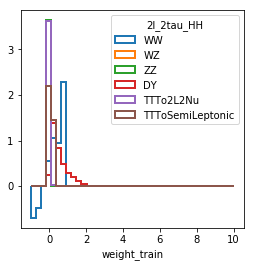

In [7]:
"""
Check of the resulting weights - the sizes of the training weight
"""
fig, ax = plt.subplots(figsize=(4, 4))
keysToBKG = ['WW', 'WZ', 'ZZ', 'DY', 'TTTo2L2Nu', 'TTToSemiLeptonic'] # 'VH', 'TTH', 'TTToHadronic', 'TTZJets', 'TTWJets' 
#colors = ['cyan','orange','k','r','green','magenta','b',]
vars = ["weight_train"]#"multitarget"]

for kk, key in enumerate(keysToBKG) :
  for vv, var in enumerate(vars) : 
    ax.hist(
        np.array(data.loc[(data['key']==key), var].values,dtype='float64'), # 
        weights=data.loc[(data['key']==key), "evtWeight"], # "weight_train_cat"
        range=(-1.0,10.),bins=40, histtype='step', normed=True, lw=2, 
        label=key
    )
    ax.set_xlabel(var)
ax.legend(loc="best", title= channel)

In [8]:
## load the variables
#trainvar = trainVars(False, "testVars2")
#print trainvar
trainvar = trainVars(False, variables, bdtType) ## = BDTvariables
print trainvar

['diHiggsMass', 'diHiggsVisMass', 'tau1_pt', 'nBJet_medium', 'gen_mHH', 'nElectron', 'dr_lep_tau_min_SS', 'met_LD', 'tau2_pt', 'dr_lep_tau_min_OS']


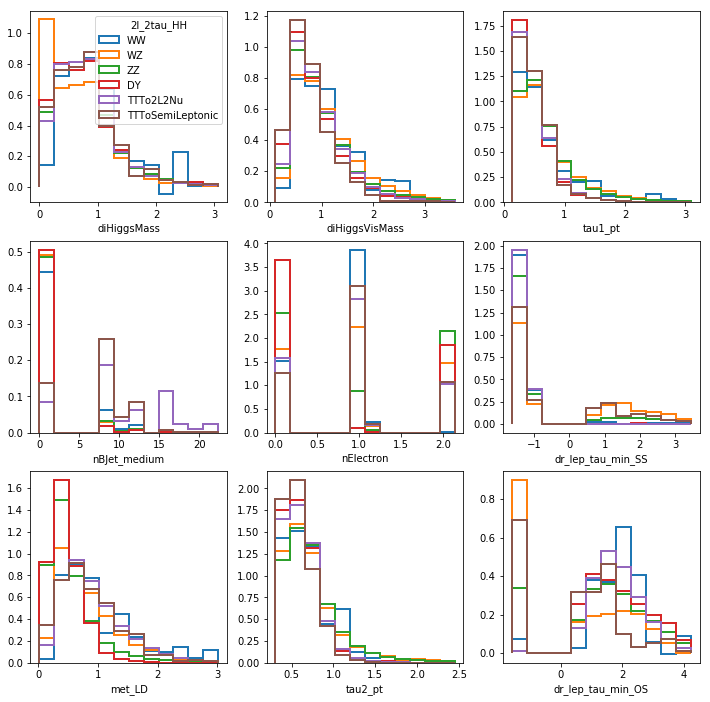

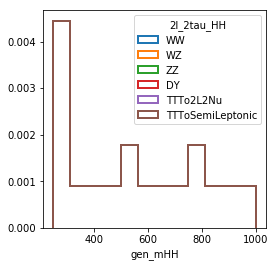

In [9]:
"""
Draw some plots on lists of variables for BKG
"""
#keysToBKG = ['TTZJets', 'WZ', 'ZZ', 'DY', 'VH', 'ttH', 'TTTo2L2Nu']
 
## i try to do 3 X 3 plots (= enter up to nine entries in each sublist)
## try to add strictly decreasing variables as first in each sublist, better for the legend positioning
#listdraw = [
#    [ 'tau1_pt', 'tau2_pt', 'mT_lep1', 'mT_lep2', 'met', 'm_ll', 'mTauTau', 'diHiggsVisMass', 'diHiggsMass' ], 
#    ['nBJet_medium', 'nElectron', 'max_tau_eta', 'max_lep_eta', 'gen_mHH'],
#]

listdraw = [
    ['diHiggsMass', 'diHiggsVisMass', 'tau1_pt', 'nBJet_medium', 'nElectron', 'dr_lep_tau_min_SS', 'met_LD', 'tau2_pt', 'dr_lep_tau_min_OS'],
    ['gen_mHH'],
           ]

for featuresDraw in listdraw:
    sizeArray=int(math.sqrt(len(featuresDraw))) if math.sqrt(len(featuresDraw)) % int(math.sqrt(len(featuresDraw))) == 0 else int(math.sqrt(len(featuresDraw)))+1
    plt.figure(figsize=(4*sizeArray,4*sizeArray))
    for n, feature in enumerate(featuresDraw) :
        min_value, max_value = np.percentile(data[feature], [0.0, 99])
        # fig, ax = plt.subplots(figsize=(4, 4))
        plt.subplot(sizeArray, sizeArray, n+1)
        for kk, key in enumerate(keysToBKG) :
            if 'TTZJets' in key or 'TTWJets' in key : linestyle = "--"
            else :linestyle = "-"
            plt.hist(
            np.array(data.loc[(data['key']==key), feature].values,dtype='float64'), 
            weights=data.loc[(data['key']==key) , "evtWeight"], 
            range=(min_value, max_value), 
            bins=12, histtype='step', ls=linestyle, 
            normed=True, lw=2, #color=colors[kk],
            label=key
            )
            plt.xlabel(feature)
        if n == 0 : plt.legend(loc="upper right", title= channel)

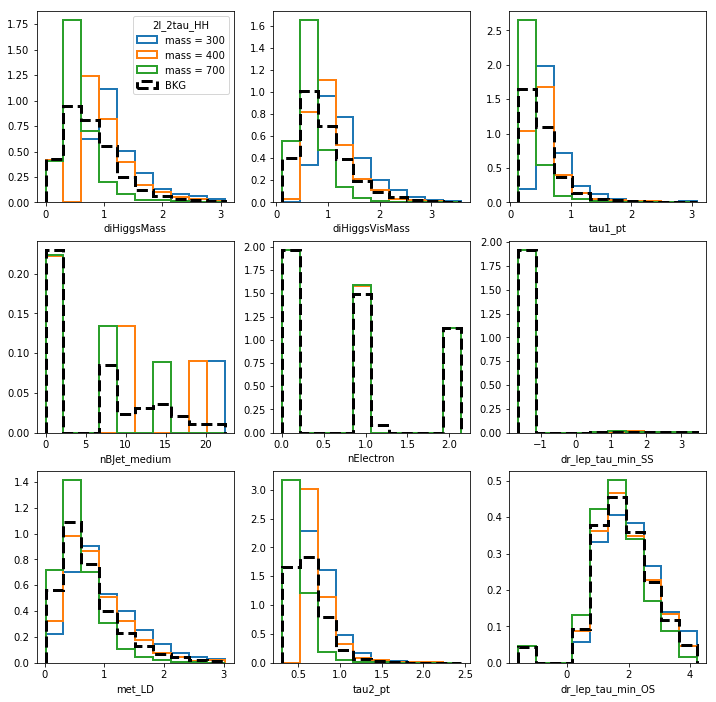

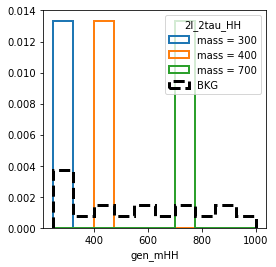

In [10]:
for featuresDraw in listdraw:
    sizeArray=int(math.sqrt(len(featuresDraw))) if math.sqrt(len(featuresDraw)) % int(math.sqrt(len(featuresDraw))) == 0 else int(math.sqrt(len(featuresDraw)))+1
    plt.figure(figsize=(4*sizeArray,4*sizeArray))
    for n, feature in enumerate(featuresDraw) :
        min_value, max_value = np.percentile(data[feature], [0.0, 99])
        # fig, ax = plt.subplots(figsize=(4, 4))
        plt.subplot(sizeArray, sizeArray, n+1)
        for mass in [300,400,700] :
            plt.hist(
            np.array(data.loc[(data["gen_mHH"] == mass), feature].values,dtype='float64'), 
            weights=data.loc[(data["gen_mHH"] == mass) , "evtWeight"], 
            range=(min_value, max_value), 
            bins=10, histtype='step', ls=linestyle, 
            normed=True, lw=2, #color=colors[kk],
            label="mass = "+str(mass)
            )
        plt.hist(
        np.array(data.loc[(data['target']==0), feature].values,dtype='float64'), 
        weights=data.loc[(data['target']==0) , "evtWeight"], 
        range=(min_value, max_value), 
        bins=10, histtype='step', ls='--', 
        normed=True, lw=3, color='k',
        label="BKG"
        )
        plt.xlabel(feature)
        if n == 0 : plt.legend(loc="upper right", title= channel)

In [11]:
# create model -- for binary activation='sigmoid'
nclasses = 1

features = trainvar # = BDTvariables
def nn_model_binary():
    "create a model."
    model = Sequential()
    model.add(Dense(2*len(features), input_dim=len(features), kernel_initializer='he_uniform')) 
    model.add(BatchNormalization())
    model.add(PReLU())
    model.add(Dropout(DROPOUT)) #0.1
    for Nnodes in [8,8] :
        model.add(Dense(Nnodes, kernel_initializer='he_uniform'))
        model.add(BatchNormalization())
        model.add(PReLU())
        model.add(Dropout(DROPOUT)) #0.1
    model.add(Dense(nclasses, activation='sigmoid'))
    model.compile(
    loss='binary_crossentropy', 
    optimizer=Nadam(lr=LR, schedule_decay=SCHEDULE_DECAY), ##  lr=0.0005, sch_dec.=0.00005   # , beta_1 = 0.95, beta_2 = 0.999
    metrics=['accuracy'], 
    )
    return model

def nn_model_binary_wo_gen_mHH():
    "create a model."
    model = Sequential()
    model.add(Dense(2*len(BDTvariables_wo_gen_mHH), input_dim=len(BDTvariables_wo_gen_mHH), kernel_initializer='he_uniform')) 
    model.add(BatchNormalization())
    model.add(PReLU())
    model.add(Dropout(DROPOUT)) #0.1
    for Nnodes in [8,8] :
        model.add(Dense(Nnodes, kernel_initializer='he_uniform'))
        model.add(BatchNormalization())
        model.add(PReLU())
        model.add(Dropout(DROPOUT)) #0.1
    model.add(Dense(nclasses, activation='sigmoid'))
    model.compile(
    loss='binary_crossentropy', 
    optimizer=Nadam(lr=LR, schedule_decay=SCHEDULE_DECAY), ##  lr=0.0005, sch_dec.=0.00005   # , beta_1 = 0.95, beta_2 = 0.999
    metrics=['accuracy'], 
    )
    return model

In [12]:
nn_model_binary().summary()
nn_model_binary_wo_gen_mHH().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 20)                220       
_________________________________________________________________
batch_normalization_1 (Batch (None, 20)                80        
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 20)                20        
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 168       
_________________________________________________________________
batch_normalization_2 (Batch (None, 8)                 32        
_________________________________________________________________
p_re_lu_2 (PReLU)            (None, 8)                 8         
__________

In [13]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import StandardScaler

In [39]:
features = trainvar
# Port Keras Framework into SK-Learn
# https://stackoverflow.com/questions/39467496/error-when-using-keras-sk-learn-api
k_model_binary  = KerasClassifier(
    build_fn=nn_model_binary, 
    epochs=EPOCHS, # 10
    batch_size=BATCH_SIZE, # 64
    verbose=2
)

print("data_odd[features].values", data_odd[features].values)
print("data_odd[target].values", data_odd['target'].values)
print("sample_weight=data_odd[weight_train].values", data_odd["weight_train"].values)

history = k_model_binary.fit(
    data_odd[features].values, 
    data_odd['target'].values,
    sample_weight=data_odd["weight_train"].values,
    validation_data=(
        data_even[features].values, 
        data_even['target'].values, 
        data_even["weight_train"].values
    )
)

('data_odd[features].values', array([[0.8094199895858765, 1.2075021266937256, 0.6241664886474609, ...,
        0.8703704476356506, 0.8964957594871521, 3.7127585411071777],
       [0.9430416226387024, 1.5530486106872559, 1.1408418416976929, ...,
        1.7482539415359497, 1.0562164783477783, 1.7053056955337524],
       [1.2136162519454956, 1.1606113910675049, 0.45046108961105347, ...,
        0.9329136610031128, 0.6422618627548218, 2.0226306915283203],
       ...,
       [1.1580690145492554, 0.5099794268608093, 0.7377614974975586, ...,
        0.9948492646217346, 0.31968697905540466, -1.5872480869293213],
       [1.153649926185608, 1.0395138263702393, 0.6917862296104431, ...,
        0.8990645408630371, 1.4478371143341064, -1.5872480869293213],
       [1.1255817413330078, 1.3981534242630005, 2.7230684757232666, ...,
        1.5387194156646729, 2.584284543991089, 0.9010608196258545]],
      dtype=object))
('data_odd[target].values', array([0, 0, 0, ..., 1, 1, 1], dtype=object))
('sample

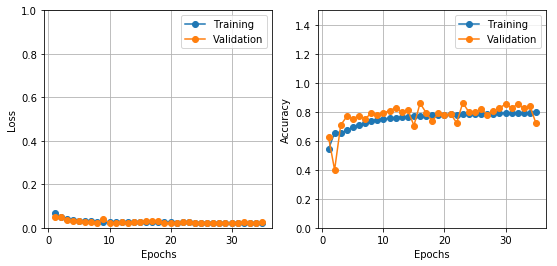

In [23]:
"""
overtraining test
"""
# Extract number of run epochs from the training history
epochs = range(1, len(history.history["loss"])+1)
plt.figure(figsize=(9, 4))
#fig = plt.figure(figsize=(4, 4))
plt.subplot(1, 2, 1)
# Extract loss on training and validation dataset and plot them together
plt.plot(epochs, history.history["loss"], "o-", label="Training")
plt.plot(epochs, history.history["val_loss"], "o-", label="Validation")
plt.xlabel("Epochs"), plt.ylabel("Loss")
#plt.yscale("log")
#plt.xlim(0,40)
plt.ylim(0.0,1.0)
plt.grid()
plt.legend(loc="best");

plt.subplot(1, 2, 2)
#fig = plt.figure(figsize=(4, 4))
# Extract loss on training and validation dataset and plot them together
plt.plot(epochs, history.history["acc"], "o-", label="Training")
plt.plot(epochs, history.history["val_acc"], "o-", label="Validation")
plt.xlabel("Epochs"), plt.ylabel("Accuracy")
#plt.yscale("log")
plt.ylim(0.0,1.5)
plt.grid()
plt.legend(loc="best")
filename1="{}/loss_and_acc_{}.pdf".format(channel, hyppar)
plt.savefig(filename1);

plt.show()

In [27]:
import sys
sys.path.append('/home/ram/.local/lib/python2.7/site-packages')
import eli5
from eli5.sklearn import PermutationImportance
"""
to calculate variables importance, it takes time and it is not completelly 'enlightant',
do not do all the time.
"""

"\nto calculate variables importance, it takes time and it is not completelly 'enlightant',\ndo not do all the time.\n"

In [28]:
print ("Date: ", time.asctime( time.localtime(time.time()) ))
perm = PermutationImportance(k_model_binary, random_state=1).fit( # , scoring="f1_samples"
    data_odd[features].values, 
    data_odd['target'].values,
    sample_weight=data_odd["weight_train"].values
)
print ("Date: ", time.asctime( time.localtime(time.time()) ))
eli5.show_weights(perm, feature_names = data_odd[features].columns.tolist(), top=len(features))

('Date: ', 'Tue Jun  4 12:38:31 2019')
('Date: ', 'Tue Jun  4 12:39:35 2019')


Weight,Feature
0.0944 ± 0.0011,gen_mHH
0.0894 ± 0.0005,diHiggsVisMass
0.0514 ± 0.0011,diHiggsMass
0.0130 ± 0.0004,met_LD
0.0104 ± 0.0007,nElectron
0.0090 ± 0.0003,nBJet_medium
0.0052 ± 0.0002,dr_lep_tau_min_SS
0.0046 ± 0.0007,tau1_pt
0.0007 ± 0.0002,dr_lep_tau_min_OS
-0.0066 ± 0.0006,tau2_pt


In [24]:
"""
Calculate the output in all dataset 
-- to pass to the training/test
"""

data_odd["NN_output"]  = k_model_binary.predict_proba(data_odd[features].values, verbose=1)[:, 1]
data_even["NN_output"] = k_model_binary.predict_proba(data_even[features].values, verbose=1)[:, 1]

 12800/344624 [>.............................] - ETA: 1s

/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.9.0-ikaegh/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


344624/344624 [==============================] - 1s 4us/step


/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.9.0-ikaegh/lib/python2.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


<Figure size 432x288 with 0 Axes>

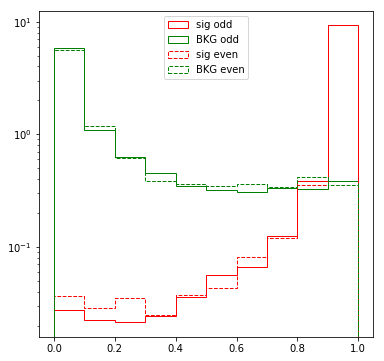

In [29]:
hist_params = {'normed': True, 'bins': 10 , 'histtype':'step'}
target = 'target'
plt.clf()

plt.figure('XGB',figsize=(6, 6))

values, bins, _ = plt.hist(
    data_odd.loc[data_odd.target.values == 1, "NN_output"].values , 
    weights=data_odd.loc[data_odd.target.values == 1, "weight_cx"].values,
    label="sig odd", color='r', range=(0,1), **hist_params
    )
values, bins, _ = plt.hist(
    data_odd.loc[data_odd.target.values == 0, "NN_output"].values , 
    weights=data_odd.loc[data_odd.target.values == 0, "weight_cx"].values,
    label="BKG odd", color='g', range=(0,1), **hist_params
    )

values, bins, _ = plt.hist(
    data_even.loc[data_even.target.values == 1, "NN_output"].values , 
    weights=(data_even.loc[data_even.target.values == 1, "weight_cx"].values),
    label="sig even", color='r', ls='--', range=(0,1), **hist_params)
values, bins, _ = plt.hist(
    data_even.loc[data_even.target.values == 0, "NN_output"].values , 
    weights=(data_even.loc[data_even.target.values == 0, "weight_cx"].values),
    label="BKG even", color='g', ls='--', range=(0,1), **hist_params)

#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper center')
filename2="{}/NN_Output_{}.pdf".format(channel, hyppar)
plt.savefig(filename2);

plt.show()



<Figure size 432x288 with 0 Axes>

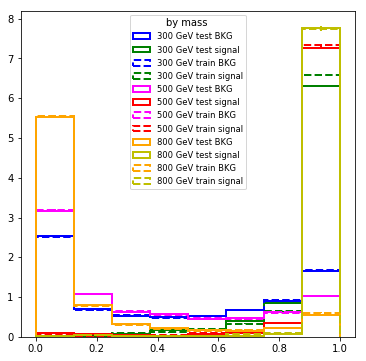

In [31]:
###############################
## classifier plot by mass
hist_params = {'normed': True, 'bins': 8 , 'histtype':'step', "lw": 2}
plt.clf()
colorcold = ['g', 'r', 'y']
colorhot = ['b', 'magenta', 'orange']

fig, ax = plt.subplots(figsize=(6, 6))
for mm, mass in enumerate(output["masses_test"]) :
    y_pred = data_even.loc[(data_even.target.values == 0) & (data_even["gen_mHH"] == mass), "NN_output"].values
    y_predS = data_even.loc[(data_even.target.values == 1) & (data_even["gen_mHH"] == mass), "NN_output"].values
    y_pred_train = data_odd.loc[(data_odd.target.values == 0) & (data_odd["gen_mHH"] == mass), "NN_output"].values
    y_predS_train = data_odd.loc[(data_odd.target.values == 1) & (data_odd["gen_mHH"] == mass), "NN_output"].values
    dict_plot = [
       [y_pred, "-", colorhot[mm],  str(mass)+" GeV test BKG"],
       [y_predS, "-", colorcold[mm], str(mass)+" GeV test signal"],
       [y_pred_train, "--", colorhot[mm], str(mass)+" GeV train BKG" ],
       [y_predS_train, "--", colorcold[mm],      str(mass)+" GeV train signal"]
    ]
    for item in dict_plot :
        values1, bins, _ = ax.hist(
            item[0],
            ls=item[1], color = item[2],
            label=item[3],
            range=(0,1),
            **hist_params
            )
        normed = sum(y_pred)
        mid = 0.5*(bins[1:] + bins[:-1])
        err=np.sqrt(values1*normed)/normed # denominator is because plot is normalized
        plt.errorbar(mid, values1, yerr=err, fmt='none', color= item[2], ecolor= item[2], edgecolor=item[2], lw=2)
#plt.xscale('log')
#plt.yscale('log')
ax.legend(loc='upper center', title="by mass ", fontsize = 'small')
#nameout = channel+'/'+bdtType+'_'+trainvar+'_'+str(len(trainVars(False)))+'_'+hyppar+'_mass_'+ str(mass)+'_XGBclassifier.pdf'

filename3="{}/NN_Output_by_mass_{}.pdf".format(channel, hyppar)
plt.savefig(filename3);

train set auc 0.9584117116499155 (mass = 300)
test set auc 0.9468566807826482 (mass = 300)
train set auc 0.9468566807826482 (mass = 300)
test set auc 0.9584117116499155 (mass = 300)
train set auc 0.9856368696979514 (mass = 500)
test set auc 0.9761152358289884 (mass = 500)
train set auc 0.9761152358289884 (mass = 500)
test set auc 0.9856368696979514 (mass = 500)
train set auc 0.9925277030187527 (mass = 800)
test set auc 0.9946226035065091 (mass = 800)
train set auc 0.9946226035065091 (mass = 800)
test set auc 0.9925277030187527 (mass = 800)


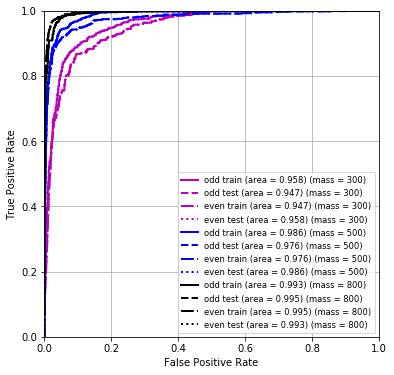

In [32]:
###############################
# by mass ROC
styleline = ['-', '--', '-.', ':']
colors_mass = ['m', 'b', 'k', 'r', 'g',  'y', 'c', ]
fig, ax = plt.subplots(figsize=(6, 6))
sl = 0


for mm, mass in enumerate(output["masses_test"]) :
    for dd, data_do in  enumerate(order_train) :
        if dd == 0 : val_data = 1
        else : val_data = 0
        fpr, tpr, thresholds = roc_curve(
            data_do.loc[(data_do["gen_mHH"] == mass), "target"].astype(np.bool),
            data_do.loc[(data_do["gen_mHH"] == mass), "NN_output"].values,
            sample_weight=(data_do.loc[(data_do["gen_mHH"].astype(np.int) == int(mass)), "weight_cx"].astype(np.float64))
        )
        train_auc = auc(fpr, tpr, reorder = True)
        print("train set auc " + str(train_auc) + " (mass = " + str(mass) + ")")
        fprt, tprt, thresholds = roc_curve(
            order_train[val_data].loc[(order_train[val_data]["gen_mHH"].astype(np.int) == int(mass)), target].astype(np.bool), 
            order_train[val_data].loc[(order_train[val_data]["gen_mHH"] == mass), "NN_output"].values, #proba[:,1],
            sample_weight=(order_train[val_data].loc[(order_train[val_data]["gen_mHH"].astype(np.int) == int(mass)), "weight_cx"].astype(np.float64))
        )
        test_auct = auc(fprt, tprt, reorder = True)
        print("test set auc " + str(test_auct) + " (mass = " + str(mass) + ")")
        ax.plot(
            fpr, tpr,
            lw = 2, linestyle = styleline[dd + dd*1], color = colors_mass[mm],
            label = order_train_name[dd] + ' train (area = %0.3f)'%(train_auc) + " (mass = " + str(mass) + ")"
            )
        sl += 1
        ax.plot(
            fprt, tprt,
            lw = 2, linestyle = styleline[dd + 1 + + dd*1], color = colors_mass[mm],
            label = order_train_name[dd] + ' test (area = %0.3f)'%(test_auct) + " (mass = " + str(mass) + ")"
            )
        sl += 1
ax.set_ylim([0.0,1.0])
ax.set_xlim([0.0,1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend(loc="lower right", fontsize = 'small')
ax.grid()

filename4="{}/ROC_by_mass_{}.pdf".format(channel, hyppar)
plt.savefig(filename4);


In [43]:
#### ----- Interpolation check log files ----####                                                                                                                                                                                                                       
for mm, mass in enumerate(test_masses): ## Loop over the test masses                                                                                                                                                                                                    
    print("mass", mass)
    MASS = int(mass)
    print("MASS", MASS)
    MASS_STR = "{}".format(MASS)
    print("MASS_STR", MASS_STR)
    
    ## For writing the interpolation check roc curves ##                                                                                                                                                                                                                
    log_file2_name = "{}/{}_{}.log".format(channel,channel,MASS_STR)
    file2_ = open(log_file2_name, 'w+')

    for dd, data_do in  enumerate(order_train):   ## Loop over the odd and even dataset halves                                                                                                                                                                          
        if dd == 0 : val_data = 1
        else : val_data = 0
        
        if(Bkg_mass_rand == "default"):
            print("Using the new logic")
            traindataset1 = data_do.loc[~((data_do["gen_mHH"]==mass) & (data_do['target']==1))]  ## Training for all masses except the one under study only for signal process                                                                                            
            #valdataset1   = order_train[val_data].loc[~((order_train[val_data]["gen_mHH"]==mass) & (order_train[val_data][target]==1))]  ## Testing for all masses except the one under study for signal process                                                       
            valdataset1 = order_train[val_data].loc[~((order_train[val_data]["gen_mHH"]!=mass) & (order_train[val_data]['target']==1))] ## Testing on only the mass under study for signal                                                                                
        else:
            print("Using the old logic")
            traindataset1 = data_do.loc[~(data_do["gen_mHH"]==mass)]  ## Training for all masses except the one under study                                                                                                                                             
            #valdataset1 = order_train[val_data].loc[~(order_train[val_data]["gen_mHH"]==mass)]  ## Testing for all masses except the one under study                                                                                                                   
            valdataset1 = order_train[val_data].loc[(order_train[val_data]["gen_mHH"]==mass)] ## Testing on only the mass under study
   
        
        if(mass == 300):
            if(TrainMode == 0):
                masses1 = [250,260,270,280,350,400,450,500,550,600,650,700,750,800,850,900,1000] ## All masses except 300                                                                                                                                               
                masses_test1 = [250,1000]
            elif(TrainMode == 1):
                masses1 = [250,260,270,280,350,400] ## Low mass only training (except 300)                                                                                                                                                                              
                masses_test1 = [250]
            masses2 = [300]
            masses_test2 = [300]
        elif(mass == 500):
            if(TrainMode == 0):
                masses1 = [250,260,270,280,300,350,400,450,550,600,650,700,750,800,850,900,1000] ## All masses except 500                                                                                                                                               
                masses_test1 = [250,1000]
            elif(TrainMode == 2):
                masses1 = [450,550,600,650,700,750,800,850,900,1000] ## High mass only training (except 500)                                                                                                                                                            
                masses_test1 = [1000]
            masses2 = [500]
            masses_test2 = [500]
        elif(mass == 800):
            if(TrainMode == 0):
                masses1 = [250,260,270,280,300,350,400,450,500,550,600,650,700,750,850,900,1000] ## All masses except 800                                                                                                                                               
                masses_test1 = [250,1000]
            elif(TrainMode == 2):
                masses1 = [450,500,550,600,650,700,750,850,900,1000] ## High mass only training (except 800)                                                                                                                                                            
                masses_test1 = [1000]
            masses2 = [800]
            masses_test2 = [800]
            
        #plot_name_train1 = "_Variables_traindataset1_BDT_"+MASS_STR+".pdf"
        #plot_name_val1 = "_Variables_valdataset1_BDT_"+MASS_STR+".pdf"

        #make_plots(BDTvariables, nbins,
        #           traindataset1.ix[traindataset1.target.values == 0],labelBKG, colorFast,
        #           traindataset1.ix[traindataset1.target.values == 1],'Signal', colorFastT,
        #           channel+"/"+bdtType+"_"+trainvar+plot_name_train1,
        #           printmin,
        #           plotResiduals,
        #           masses_test1,
        #           masses1
        #           )

        #make_plots(BDTvariables, nbins,
        #           valdataset1.ix[valdataset1.target.values == 0],labelBKG, colorFast,
        #           valdataset1.ix[valdataset1.target.values == 1],'Signal', colorFastT,
        #           channel+"/"+bdtType+"_"+trainvar+plot_name_val1,
        #           printmin,
        #           plotResiduals,
        #           masses_test2,
        #           [250.,260.,270.,280.,300.,350.,400.,450.,500.,550.,600.,650.,700.,750.,800.,850.,900.,1000.]
        #           )

        ################# WITH gen_mHH #####################                                                                                                                                                                                                            
        k_model_binary2  = KerasClassifier(
                       build_fn=nn_model_binary, 
                       epochs=EPOCHS, # 10
                       batch_size=BATCH_SIZE, # 64
                       verbose=2
                       )
        
        history2 = k_model_binary2.fit(
               traindataset1[features].values, 
               traindataset1['target'].values,
               sample_weight=traindataset1["weight_train"].values,
               validation_data=(
                   valdataset1[features].values, 
                   valdataset1['target'].values, 
                   valdataset1["weight_train"].values
               )
        )

        traindataset1["NN_output2"] = 1.0
        valdataset1["NN_output2"]   = 1.0
        
        ## --- ROC curve ----##                                                                                                                                                                                                                                         
        #proba = cls2.predict_proba(valdataset1[trainVars(False, options.variables, options.bdtType)].values )
        valdataset1["NN_output2"] = k_model_binary2.predict_proba(valdataset1[features].values, verbose=1)[:, 1]
        fprt, tprt, thresholds = roc_curve(valdataset1['target'].astype(np.bool), valdataset1["NN_output2"].values, sample_weight=(valdataset1["weight_cx"].astype(np.float64)) )
        test_auct = auc(fprt, tprt, reorder = True)

        #proba = cls2.predict_proba(traindataset1[trainVars(False, options.variables, options.bdtType)].values )
        traindataset1["NN_output2"] = k_model_binary2.predict_proba(traindataset1[features].values, verbose=1)[:, 1]
        fpr, tpr, thresholds = roc_curve(traindataset1['target'].astype(np.bool), traindataset1["NN_output2"].values, sample_weight=(traindataset1["weight_cx"].astype(np.float64)) )
        train_auc = auc(fpr, tpr, reorder = True)

        ## ---- BDT Output Distributions ----- ###                                                                                                                                                                                                                      
        y_pred = k_model_binary2.predict_proba(valdataset1.ix[valdataset1.target.values == 0, BDTvariables].values)[:, 1]
        y_predS = k_model_binary2.predict_proba(valdataset1.ix[valdataset1.target.values == 1, BDTvariables].values)[:, 1]
        
         
        y_pred_train = k_model_binary2.predict_proba(traindataset1.ix[traindataset1.target.values == 0, BDTvariables].values)[:, 1]
        y_predS_train = k_model_binary2.predict_proba(traindataset1.ix[traindataset1.target.values == 1, BDTvariables].values)[:, 1]

        file2_.write('#------ Training for all masses except %0.1f GeV-------\n' %mass)
        file2_.write('#------ Testing only for mass %0.1f GeV (using other dataset half)--------\n' %mass)
        if(dd == 0): ## Train->odd; Test/val -> even                                                                                                                                                                                                                    
            file2_.write('train_auc_ODD0_%s = %0.8f\n' % (MASS_STR, train_auc))
            file2_.write('test_auc_EVEN0_%s  = %0.8f\n' % (MASS_STR, test_auct))
            file2_.write('xtrain_ODD0_%s = ' % (MASS_STR))
            file2_.write(str(fpr.tolist()))
            file2_.write('\n')
            file2_.write('ytrain_ODD0_%s = ' % (MASS_STR))
            file2_.write(str(tpr.tolist()))
            file2_.write('\n')
            file2_.write('xval_EVEN0_%s = ' % (MASS_STR))
            file2_.write(str(fprt.tolist()))
            file2_.write('\n')
            file2_.write('yval_EVEN0_%s = ' % (MASS_STR))
            file2_.write(str(tprt.tolist()))
            file2_.write('\n')
            file2_.write('y_pred_test_EVEN0_%s = ' % (MASS_STR))
            file2_.write(str(y_pred.tolist()))
            file2_.write('\n')
            file2_.write('y_predS_test_EVEN0_%s = ' % (MASS_STR))
            file2_.write(str(y_predS.tolist()))
            file2_.write('\n')
            file2_.write('y_pred_train_ODD0_%s = ' % (MASS_STR))
            file2_.write(str(y_pred_train.tolist()))
            file2_.write('\n')
            file2_.write('y_predS_train_ODD0_%s = ' % (MASS_STR))
            file2_.write(str(y_predS_train.tolist()))
            file2_.write('\n')
        else: ## Train->even; Test/val -> odd                                                                                                                                                                                                                           
            file2_.write('train_auc_EVEN0_%s = %0.8f\n' %  (MASS_STR, train_auc))
            file2_.write('test_auc_ODD0_%s  = %0.8f\n' %  (MASS_STR, test_auct))
            file2_.write('xtrain_EVEN0_%s = ' % (MASS_STR))
            file2_.write(str(fpr.tolist()))
            file2_.write('\n')
            file2_.write('ytrain_EVEN0_%s = ' % (MASS_STR))
            file2_.write(str(tpr.tolist()))
            file2_.write('\n')
            file2_.write('xval_ODD0_%s = ' % (MASS_STR))
            file2_.write(str(fprt.tolist()))
            file2_.write('\n')
            file2_.write('yval_ODD0_%s = ' % (MASS_STR))
            file2_.write(str(tprt.tolist()))
            file2_.write('\n')
            file2_.write('y_pred_test_ODD0_%s = ' % (MASS_STR))
            file2_.write(str(y_pred.tolist()))
            file2_.write('\n')
            file2_.write('y_predS_test_ODD0_%s = ' % (MASS_STR))
            file2_.write(str(y_predS.tolist()))
            file2_.write('\n')
            file2_.write('y_pred_train_EVEN0_%s = ' % (MASS_STR))
            file2_.write(str(y_pred_train.tolist()))
            file2_.write('\n')
            file2_.write('y_predS_train_EVEN0_%s = ' % (MASS_STR))
            file2_.write(str(y_predS_train.tolist()))
            file2_.write('\n')
        file2_.write('##-------------------------------------------##\n')
        ###################################################  
            
            
        ################# W/O gen_mHH #####################                                                                                                                                                                                                             
        k_model_binary2a = KerasClassifier(
                       build_fn=nn_model_binary_wo_gen_mHH, 
                       epochs=EPOCHS, # 10
                       batch_size=BATCH_SIZE, # 64
                       verbose=2
                       )

        history2a = k_model_binary2a.fit(
               traindataset1[BDTvariables_wo_gen_mHH].values, 
               traindataset1['target'].values,
               sample_weight=traindataset1["weight_train"].values,
               validation_data=(
                   valdataset1[BDTvariables_wo_gen_mHH].values, 
                   valdataset1['target'].values, 
                   valdataset1["weight_train"].values
               )
        )

        traindataset1["NN_output2a"] = 1.0
        valdataset1["NN_output2a"]   = 1.0
        
        ## --- ROC curve ----##                                                                                                                                                                                                                                         
        #proba_a = cls2a.predict_proba(valdataset1[BDTvariables_wo_gen_mHH].values )
        valdataset1["NN_output2a"] = k_model_binary2a.predict_proba(valdataset1[BDTvariables_wo_gen_mHH].values )
        fprt_a, tprt_a, thresholds = roc_curve(valdataset1['target'].astype(np.bool), valdataset1["NN_output2a"].values, sample_weight=(valdataset1["weight_cx"].astype(np.float64))  )
        test_auct_a = auc(fprt_a, tprt_a, reorder = True)

        #proba_a = cls2a.predict_proba(traindataset1[BDTvariables_wo_gen_mHH].values )
        traindataset1["NN_output2a"] = k_model_binary2a.predict_proba(traindataset1[BDTvariables_wo_gen_mHH].values )
        fpr_a, tpr_a, thresholds = roc_curve(traindataset1['target'].astype(np.bool), traindataset1["NN_output2a"].values, sample_weight=(traindataset1["weight_cx"].astype(np.float64)) )
        train_auc_a = auc(fpr_a, tpr_a, reorder = True)

        ## ---- BDT Output Distributions ----- ###                                                                                                                                                                                                                      
        y_pred_a = k_model_binary2a.predict_proba(valdataset1.ix[valdataset1.target.values == 0, BDTvariables_wo_gen_mHH].values)[:, 1]
        y_predS_a = k_model_binary2a.predict_proba(valdataset1.ix[valdataset1.target.values == 1, BDTvariables_wo_gen_mHH].values)[:, 1]

        y_pred_train_a = k_model_binary2a.predict_proba(traindataset1.ix[traindataset1.target.values == 0, BDTvariables_wo_gen_mHH].values)[:, 1]
        y_predS_train_a = k_model_binary2a.predict_proba(traindataset1.ix[traindataset1.target.values == 1, BDTvariables_wo_gen_mHH].values)[:, 1]
        
        file2_.write('#------ Training for all masses except %0.1f GeV (w/o gen_mHH)-------\n' %mass)
        file2_.write('#------ Testing only for mass %0.1f GeV using other dataset half (w/o gen_mHH)--------\n' %mass)
        if(dd == 0): ## Train->odd; Test/val -> even                                                                                                                                                                                                                    
            file2_.write('train_auc_ODD0a_%s = %0.8f\n' % (MASS_STR, train_auc_a))
            file2_.write('test_auc_EVEN0a_%s  = %0.8f\n' % (MASS_STR, test_auct_a))
            file2_.write('xtrain_ODD0a_%s = ' % (MASS_STR))
            file2_.write(str(fpr_a.tolist()))
            file2_.write('\n')
            file2_.write('ytrain_ODD0a_%s = ' % (MASS_STR))
            file2_.write(str(tpr_a.tolist()))
            file2_.write('\n')
            file2_.write('xval_EVEN0a_%s = ' % (MASS_STR))
            file2_.write(str(fprt_a.tolist()))
            file2_.write('\n')
            file2_.write('yval_EVEN0a_%s = ' % (MASS_STR))
            file2_.write(str(tprt_a.tolist()))
            file2_.write('\n')
            file2_.write('y_pred_test_EVEN0a_%s = ' % (MASS_STR))
            file2_.write(str(y_pred_a.tolist()))
            file2_.write('\n')
            file2_.write('y_predS_test_EVEN0a_%s = ' % (MASS_STR))
            file2_.write(str(y_predS_a.tolist()))
            file2_.write('\n')
            file2_.write('y_pred_train_ODD0a_%s = ' % (MASS_STR))
            file2_.write(str(y_pred_train_a.tolist()))
            file2_.write('\n')
            file2_.write('y_predS_train_ODD0a_%s = ' % (MASS_STR))
            file2_.write(str(y_predS_train_a.tolist()))
            file2_.write('\n')
        else: ## Train->even; Test/val -> odd                                                                                                                                                                                                                           
            file2_.write('train_auc_EVEN0a_%s = %0.8f\n' %  (MASS_STR, train_auc_a))
            file2_.write('test_auc_ODD0a_%s  = %0.8f\n' %  (MASS_STR, test_auct_a))
            file2_.write('xtrain_EVEN0a_%s = ' % (MASS_STR))
            file2_.write(str(fpr_a.tolist()))
            file2_.write('\n')
            file2_.write('ytrain_EVEN0a_%s = ' % (MASS_STR))
            file2_.write(str(tpr_a.tolist()))
            file2_.write('\n')
            file2_.write('xval_ODD0a_%s = ' % (MASS_STR))
            file2_.write(str(fprt_a.tolist()))
            file2_.write('\n')
            file2_.write('yval_ODD0a_%s = ' % (MASS_STR))
            file2_.write(str(tprt_a.tolist()))
            file2_.write('\n')
            file2_.write('y_pred_test_ODD0a_%s = ' % (MASS_STR))
            file2_.write(str(y_pred_a.tolist()))
            file2_.write('\n')
            file2_.write('y_predS_test_ODD0a_%s = ' % (MASS_STR))
            file2_.write(str(y_predS_a.tolist()))
            file2_.write('\n')
            file2_.write('y_pred_train_EVEN0a_%s = ' % (MASS_STR))
            file2_.write(str(y_pred_train_a.tolist()))
            file2_.write('\n')
            file2_.write('y_predS_train_EVEN0a_%s = ' % (MASS_STR))
            file2_.write(str(y_predS_train_a.tolist()))
            file2_.write('\n')
        file2_.write('##-------------------------------------------##\n')
        ################################################### 
        
        ## --- ROC curve ----##                                                                                                                                                                                                                                         
        if(Bkg_mass_rand == "default"):
            print("Using the new logic")
            #traindataset2 = data_do.loc[(data_do["gen_mHH"]==mass)]  ## Training for only the mass point under study                                                                                                                                                   
            traindataset2 = data_do.loc[ ~((data_do["gen_mHH"]!=mass) & (data_do['target']==1)) ]  ## Training for only the mass point under study (for the signal process)                                                                                               
            valdataset2 = order_train[val_data].loc[ ~((order_train[val_data]["gen_mHH"]!=mass) & (order_train[val_data]['target']==1)) ]  ## Testing for only the mass point under study (for the signal process)                                                        
        else:
            print("Using the old logic")
            traindataset2 = data_do.loc[(data_do["gen_mHH"]==mass)]  ## Training for only the mass point under study                                                                                                                                                    
            valdataset2 = order_train[val_data].loc[(order_train[val_data]["gen_mHH"]==mass)]  ## Testing for only the mass point under study                                                                                                                           

        #traindataset2 = data_do.loc[(data_do["gen_mHH"]==mass)]  ## Training for only the mass point under study                                                                                                                                                       
        #valdataset2 = order_train[val_data].loc[(order_train[val_data]["gen_mHH"]==mass)]  ## Testing for only the mass point under study                                                                                                                              

        #plot_name_train2 = "_Variables_traindataset2_BDT_"+MASS_STR+".pdf"
        #plot_name_val2 = "_Variables_valdataset2_BDT_"+MASS_STR+".pdf"

        #make_plots(BDTvariables, nbins,
        #           traindataset2.ix[traindataset2.target.values == 0],labelBKG, colorFast,
        #           traindataset2.ix[traindataset2.target.values == 1],'Signal', colorFastT,
        #           channel+"/"+bdtType+"_"+trainvar+plot_name_train2,
        #           printmin,
        #           plotResiduals,
        #           masses_test2,
        #           masses2
        #           )

        #make_plots(BDTvariables, nbins,
        #           valdataset2.ix[valdataset2.target.values == 0],labelBKG, colorFast,
        #           valdataset2.ix[valdataset2.target.values == 1],'Signal', colorFastT,
        #           channel+"/"+bdtType+"_"+trainvar+plot_name_val2,
        #           printmin,
        #           plotResiduals,
        #           masses_test2,
        #           masses2
        #           )

        k_model_binary3 = KerasClassifier(
                       build_fn=nn_model_binary_wo_gen_mHH, 
                       epochs=EPOCHS, # 10
                       batch_size=BATCH_SIZE, # 64
                       verbose=2
                       )
        
        history3 = k_model_binary3.fit(
               traindataset2[BDTvariables_wo_gen_mHH].values, ## Since we are doing single mass train no need for gen_mHH
               traindataset2['target'].values,
               sample_weight=traindataset2["weight_train"].values,
               validation_data=(
                   valdataset2[BDTvariables_wo_gen_mHH].values, 
                   valdataset2['target'].values, 
                   valdataset2["weight_train"].values
               )
        )
        
        traindataset2["NN_output3"] = 1.0
        valdataset2["NN_output3"]   = 1.0
        
        #proba = cls3.predict_proba(valdataset2[BDTvariables_wo_gen_mHH].values ) ## Since we are doing single mass train no need for gen_mHH                                                                                                                            
        valdataset2["NN_output3"] = k_model_binary3.predict_proba(valdataset2[BDTvariables_wo_gen_mHH].values ) ## Since we are doing single mass train no need for gen_mHH                                                                                                                            
        fprt, tprt, thresholds = roc_curve(valdataset2['target'].astype(np.bool), valdataset2["NN_output3"].values, sample_weight=(valdataset2["weight_cx"].astype(np.float64))  )
        print("fprt", fprt)
        print("tprt", tprt)
        test_auct = auc(fprt, tprt, reorder = True)

        #proba = cls3.predict_proba(traindataset2[BDTvariables_wo_gen_mHH].values ) ## Since we are doing single mass train no need for gen_mHH                                                                                                                          
        traindataset2["NN_output3"] = k_model_binary3.predict_proba(traindataset2[BDTvariables_wo_gen_mHH].values ) ## Since we are doing single mass train no need for gen_mHH                                                                                                                          
        fpr, tpr, thresholds = roc_curve(traindataset2['target'].astype(np.bool), traindataset2["NN_output3"].values, sample_weight=(traindataset2["weight_cx"].astype(np.float64)) )
        train_auc = auc(fpr, tpr, reorder = True)

        ## ---- BDT Output Distributions ----- ###                                                                                                                                                                                                                      
        y_pred = k_model_binary3.predict_proba(valdataset2.ix[valdataset2.target.values == 0, BDTvariables_wo_gen_mHH].values)[:, 1]   ## Since we are doing single mass train no need for gen_mHH                                                                                 
        y_predS = k_model_binary3.predict_proba(valdataset2.ix[valdataset2.target.values == 1, BDTvariables_wo_gen_mHH].values)[:, 1]  ## Since we are doing single mass train no need for gen_mHH                                                                                 

        y_pred_train = k_model_binary3.predict_proba(traindataset2.ix[traindataset2.target.values == 0, BDTvariables_wo_gen_mHH].values)[:, 1]  ## Since we are doing single mass train no need for gen_mHH                                                                        
        y_predS_train = k_model_binary3.predict_proba(traindataset2.ix[traindataset2.target.values == 1, BDTvariables_wo_gen_mHH].values)[:, 1] ## Since we are doing single mass train no need for gen_mHH 
        
        file2_.write('#------ Training for only mass %0.1f GeV-------\n' %mass)
        file2_.write('#------ Testing for only mass %0.1f GeV (using other data half)--------\n' %mass)
        if(dd == 0): ## Train->odd; Test/val -> even                                                                                                                                                                                                                    
            file2_.write('train_auc_ODD1_%s = %0.8f\n' % (MASS_STR, train_auc))
            file2_.write('test_auc_EVEN1_%s  = %0.8f\n' % (MASS_STR, test_auct))
            file2_.write('xtrain_ODD1_%s = ' % (MASS_STR))
            file2_.write(str(fpr.tolist()))
            file2_.write('\n')
            file2_.write('ytrain_ODD1_%s = ' % (MASS_STR))
            file2_.write(str(tpr.tolist()))
            file2_.write('\n')
            file2_.write('xval_EVEN1_%s = ' % (MASS_STR))
            file2_.write(str(fprt.tolist()))
            file2_.write('\n')
            file2_.write('yval_EVEN1_%s = ' % (MASS_STR))
            file2_.write(str(tprt.tolist()))
            file2_.write('\n')
            file2_.write('y_pred_test_EVEN1_%s = ' % (MASS_STR))
            file2_.write(str(y_pred.tolist()))
            file2_.write('\n')
            file2_.write('y_predS_test_EVEN1_%s = ' % (MASS_STR))
            file2_.write(str(y_predS.tolist()))
            file2_.write('\n')
            file2_.write('y_pred_train_ODD1_%s = ' % (MASS_STR))
            file2_.write(str(y_pred_train.tolist()))
            file2_.write('\n')
            file2_.write('y_predS_train_ODD1_%s = ' % (MASS_STR))
            file2_.write(str(y_predS_train.tolist()))
            file2_.write('\n')
        else: ## Train->even; Test/val -> odd                                                                                                                                                                                                                           
            file2_.write('train_auc_EVEN1_%s = %0.8f\n' %  (MASS_STR, train_auc))
            file2_.write('test_auc_ODD1_%s  = %0.8f\n' % (MASS_STR, test_auct))
            file2_.write('xtrain_EVEN1_%s = ' % (MASS_STR))
            file2_.write(str(fpr.tolist()))
            file2_.write('\n')
            file2_.write('ytrain_EVEN1_%s = ' % (MASS_STR))
            file2_.write(str(tpr.tolist()))
            file2_.write('\n')
            file2_.write('xval_ODD1_%s = ' % (MASS_STR))
            file2_.write(str(fprt.tolist()))
            file2_.write('\n')
            file2_.write('yval_ODD1_%s = ' % (MASS_STR))
            file2_.write(str(tprt.tolist()))
            file2_.write('\n')
            file2_.write('y_pred_test_ODD1_%s = ' % (MASS_STR))
            file2_.write(str(y_pred.tolist()))
            file2_.write('\n')
            file2_.write('y_predS_test_ODD1_%s = ' % (MASS_STR))
            file2_.write(str(y_predS.tolist()))
            file2_.write('\n')
            file2_.write('y_pred_train_EVEN1_%s = ' % (MASS_STR))
            file2_.write(str(y_pred_train.tolist()))
            file2_.write('\n')
            file2_.write('y_predS_train_EVEN1_%s = ' % (MASS_STR))
            file2_.write(str(y_predS_train.tolist()))
            file2_.write('\n')
        file2_.write('##-------------------------------------------##\n')
    file2_.close()
### ---------------------------------------- #### 
        
            

('mass', 300)
('MASS', 300)
('MASS_STR', '300')
Using the old logic
Train on 324608 samples, validate on 18428 samples
Epoch 1/35
 - 3s - loss: 0.0604 - acc: 0.5363 - val_loss: 0.0558 - val_acc: 0.5572
Epoch 2/35
 - 3s - loss: 0.0419 - acc: 0.6331 - val_loss: 0.0517 - val_acc: 0.5355
Epoch 3/35
 - 3s - loss: 0.0379 - acc: 0.6280 - val_loss: 0.0488 - val_acc: 0.5650
Epoch 4/35
 - 3s - loss: 0.0343 - acc: 0.6621 - val_loss: 0.0452 - val_acc: 0.5519
Epoch 5/35
 - 3s - loss: 0.0313 - acc: 0.6931 - val_loss: 0.0414 - val_acc: 0.5553
Epoch 6/35
 - 3s - loss: 0.0290 - acc: 0.7171 - val_loss: 0.0406 - val_acc: 0.5496
Epoch 7/35
 - 3s - loss: 0.0281 - acc: 0.7333 - val_loss: 0.0396 - val_acc: 0.6529
Epoch 8/35
 - 3s - loss: 0.0272 - acc: 0.7435 - val_loss: 0.0365 - val_acc: 0.6267
Epoch 9/35
 - 3s - loss: 0.0267 - acc: 0.7528 - val_loss: 0.0374 - val_acc: 0.5779
Epoch 10/35
 - 3s - loss: 0.0261 - acc: 0.7580 - val_loss: 0.0363 - val_acc: 0.6846
Epoch 11/35
 - 3s - loss: 0.0260 - acc: 0.7618 - v

/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.9.0-ikaegh/lib/python2.7/site-packages/ipykernel_launcher.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.9.0-ikaegh/lib/python2.7/site-packages/ipykernel_launcher.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


 13056/324608 [>.............................] - ETA: 1s

/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.9.0-ikaegh/lib/python2.7/site-packages/ipykernel_launcher.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


324608/324608 [==============================] - 1s 4us/step


/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.9.0-ikaegh/lib/python2.7/site-packages/ipykernel_launcher.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.9.0-ikaegh/lib/python2.7/site-packages/ipykernel_launcher.py:114: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.9.0-ikaegh/lib/python2.7/site-packages/ipykernel_launcher.py:115: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See 

Train on 324608 samples, validate on 18428 samples
Epoch 1/35
 - 3s - loss: 0.0579 - acc: 0.4885 - val_loss: 0.0505 - val_acc: 0.4483
Epoch 2/35
 - 3s - loss: 0.0380 - acc: 0.6721 - val_loss: 0.0440 - val_acc: 0.4797
Epoch 3/35
 - 3s - loss: 0.0337 - acc: 0.7025 - val_loss: 0.0414 - val_acc: 0.5181
Epoch 4/35
 - 3s - loss: 0.0311 - acc: 0.7170 - val_loss: 0.0398 - val_acc: 0.5456
Epoch 5/35
 - 3s - loss: 0.0295 - acc: 0.7340 - val_loss: 0.0387 - val_acc: 0.5512
Epoch 6/35
 - 3s - loss: 0.0289 - acc: 0.7444 - val_loss: 0.0384 - val_acc: 0.5567
Epoch 7/35
 - 3s - loss: 0.0281 - acc: 0.7517 - val_loss: 0.0379 - val_acc: 0.5646
Epoch 8/35
 - 3s - loss: 0.0274 - acc: 0.7581 - val_loss: 0.0369 - val_acc: 0.5941
Epoch 9/35
 - 3s - loss: 0.0270 - acc: 0.7638 - val_loss: 0.0374 - val_acc: 0.5796
Epoch 10/35
 - 3s - loss: 0.0268 - acc: 0.7675 - val_loss: 0.0363 - val_acc: 0.5967
Epoch 11/35
 - 3s - loss: 0.0266 - acc: 0.7699 - val_loss: 0.0367 - val_acc: 0.5946
Epoch 12/35
 - 3s - loss: 0.0264 -

/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.9.0-ikaegh/lib/python2.7/site-packages/ipykernel_launcher.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.9.0-ikaegh/lib/python2.7/site-packages/ipykernel_launcher.py:201: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.9.0-ikaegh/lib/python2.7/site-packages/ipykernel_launcher.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

Using the old logic
Train on 18305 samples, validate on 18428 samples
Epoch 1/35
 - 0s - loss: 0.0837 - acc: 0.8317 - val_loss: 0.0741 - val_acc: 0.8753
Epoch 2/35
 - 0s - loss: 0.0703 - acc: 0.7022 - val_loss: 0.0687 - val_acc: 0.6981
Epoch 3/35
 - 0s - loss: 0.0659 - acc: 0.6480 - val_loss: 0.0645 - val_acc: 0.6363
Epoch 4/35
 - 0s - loss: 0.0628 - acc: 0.6076 - val_loss: 0.0614 - val_acc: 0.5949
Epoch 5/35
 - 0s - loss: 0.0626 - acc: 0.5993 - val_loss: 0.0593 - val_acc: 0.5798
Epoch 6/35
 - 0s - loss: 0.0595 - acc: 0.5847 - val_loss: 0.0578 - val_acc: 0.5729
Epoch 7/35
 - 0s - loss: 0.0582 - acc: 0.5870 - val_loss: 0.0562 - val_acc: 0.5771
Epoch 8/35
 - 0s - loss: 0.0582 - acc: 0.5791 - val_loss: 0.0554 - val_acc: 0.5741
Epoch 9/35
 - 0s - loss: 0.0558 - acc: 0.5821 - val_loss: 0.0545 - val_acc: 0.5725
Epoch 10/35
 - 0s - loss: 0.0562 - acc: 0.5795 - val_loss: 0.0535 - val_acc: 0.5696
Epoch 11/35
 - 0s - loss: 0.0548 - acc: 0.5814 - val_loss: 0.0524 - val_acc: 0.5641
Epoch 12/35
 - 

/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.9.0-ikaegh/lib/python2.7/site-packages/ipykernel_launcher.py:335: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.9.0-ikaegh/lib/python2.7/site-packages/ipykernel_launcher.py:336: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.9.0-ikaegh/lib/python2.7/site-packages/ipykernel_launcher.py:339: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

('fprt', array([0.00000000e+00, 6.64980292e-04, 9.85580067e-04, ...,
       9.99998280e-01, 9.99998280e-01, 1.00000000e+00]))
('tprt', array([0.        , 0.        , 0.        , ..., 0.99801423, 1.        ,
       1.        ]))


/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.9.0-ikaegh/lib/python2.7/site-packages/ipykernel_launcher.py:346: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.9.0-ikaegh/lib/python2.7/site-packages/ipykernel_launcher.py:351: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.9.0-ikaegh/lib/python2.7/site-packages/ipykernel_launcher.py:352: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See 

Using the old logic
Train on 326196 samples, validate on 18305 samples
Epoch 1/35
 - 3s - loss: 0.0602 - acc: 0.4277 - val_loss: 0.0547 - val_acc: 0.4274
Epoch 2/35
 - 3s - loss: 0.0411 - acc: 0.6354 - val_loss: 0.0496 - val_acc: 0.5004
Epoch 3/35
 - 3s - loss: 0.0336 - acc: 0.6699 - val_loss: 0.0410 - val_acc: 0.5642
Epoch 4/35
 - 3s - loss: 0.0301 - acc: 0.7087 - val_loss: 0.0400 - val_acc: 0.5059
Epoch 5/35
 - 3s - loss: 0.0283 - acc: 0.7333 - val_loss: 0.0457 - val_acc: 0.4404
Epoch 6/35
 - 3s - loss: 0.0270 - acc: 0.7486 - val_loss: 0.0463 - val_acc: 0.4347
Epoch 7/35
 - 3s - loss: 0.0266 - acc: 0.7552 - val_loss: 0.0388 - val_acc: 0.5106
Epoch 8/35
 - 4s - loss: 0.0260 - acc: 0.7645 - val_loss: 0.0350 - val_acc: 0.6848
Epoch 9/35
 - 3s - loss: 0.0255 - acc: 0.7684 - val_loss: 0.0332 - val_acc: 0.6278
Epoch 10/35
 - 3s - loss: 0.0252 - acc: 0.7747 - val_loss: 0.0330 - val_acc: 0.7084
Epoch 11/35
 - 3s - loss: 0.0252 - acc: 0.7788 - val_loss: 0.0330 - val_acc: 0.7112
Epoch 12/35
 -

 - 0s - loss: 0.0478 - acc: 0.5625 - val_loss: 0.0405 - val_acc: 0.5603
Epoch 26/35
 - 0s - loss: 0.0454 - acc: 0.5702 - val_loss: 0.0399 - val_acc: 0.5629
Epoch 27/35
 - 0s - loss: 0.0440 - acc: 0.5811 - val_loss: 0.0394 - val_acc: 0.5753
Epoch 28/35
 - 0s - loss: 0.0443 - acc: 0.5870 - val_loss: 0.0391 - val_acc: 0.5771
Epoch 29/35
 - 0s - loss: 0.0431 - acc: 0.5897 - val_loss: 0.0382 - val_acc: 0.5888
Epoch 30/35
 - 0s - loss: 0.0430 - acc: 0.5909 - val_loss: 0.0383 - val_acc: 0.5901
Epoch 31/35
 - 0s - loss: 0.0439 - acc: 0.5940 - val_loss: 0.0381 - val_acc: 0.5880
Epoch 32/35
 - 0s - loss: 0.0416 - acc: 0.5969 - val_loss: 0.0374 - val_acc: 0.6018
Epoch 33/35
 - 0s - loss: 0.0424 - acc: 0.5927 - val_loss: 0.0376 - val_acc: 0.5906
Epoch 34/35
 - 0s - loss: 0.0421 - acc: 0.6001 - val_loss: 0.0373 - val_acc: 0.6013
Epoch 35/35
 - 0s - loss: 0.0437 - acc: 0.6040 - val_loss: 0.0374 - val_acc: 0.6201
('fprt', array([0.        , 0.00208755, 0.00212557, ..., 1.        , 1.        ,
       

Epoch 12/35
 - 0s - loss: 0.0437 - acc: 0.5566 - val_loss: 0.0394 - val_acc: 0.5689
Epoch 13/35
 - 0s - loss: 0.0412 - acc: 0.5741 - val_loss: 0.0387 - val_acc: 0.5733
Epoch 14/35
 - 0s - loss: 0.0397 - acc: 0.5805 - val_loss: 0.0373 - val_acc: 0.5922
Epoch 15/35
 - 0s - loss: 0.0379 - acc: 0.5858 - val_loss: 0.0365 - val_acc: 0.6042
Epoch 16/35
 - 0s - loss: 0.0378 - acc: 0.5926 - val_loss: 0.0357 - val_acc: 0.6125
Epoch 17/35
 - 0s - loss: 0.0373 - acc: 0.5885 - val_loss: 0.0351 - val_acc: 0.6167
Epoch 18/35
 - 0s - loss: 0.0382 - acc: 0.6056 - val_loss: 0.0345 - val_acc: 0.6260
Epoch 19/35
 - 0s - loss: 0.0354 - acc: 0.6053 - val_loss: 0.0343 - val_acc: 0.6175
Epoch 20/35
 - 0s - loss: 0.0364 - acc: 0.6072 - val_loss: 0.0337 - val_acc: 0.6251
Epoch 21/35
 - 0s - loss: 0.0356 - acc: 0.6090 - val_loss: 0.0334 - val_acc: 0.6275
Epoch 22/35
 - 0s - loss: 0.0360 - acc: 0.6166 - val_loss: 0.0335 - val_acc: 0.6239
Epoch 23/35
 - 0s - loss: 0.0347 - acc: 0.6226 - val_loss: 0.0328 - val_acc:

Epoch 35/35
 - 3s - loss: 0.0236 - acc: 0.7866 - val_loss: 0.0194 - val_acc: 0.7892
Using the old logic
Train on 18764 samples, validate on 18632 samples
Epoch 1/35
 - 0s - loss: 0.0720 - acc: 0.7931 - val_loss: 0.0659 - val_acc: 0.5813
Epoch 2/35
 - 0s - loss: 0.0671 - acc: 0.7360 - val_loss: 0.0601 - val_acc: 0.5976
Epoch 3/35
 - 0s - loss: 0.0609 - acc: 0.6925 - val_loss: 0.0570 - val_acc: 0.6146
Epoch 4/35
 - 0s - loss: 0.0595 - acc: 0.6722 - val_loss: 0.0544 - val_acc: 0.6492
Epoch 5/35
 - 0s - loss: 0.0565 - acc: 0.6541 - val_loss: 0.0519 - val_acc: 0.6652
Epoch 6/35
 - 0s - loss: 0.0534 - acc: 0.6384 - val_loss: 0.0492 - val_acc: 0.6573
Epoch 7/35
 - 0s - loss: 0.0513 - acc: 0.6369 - val_loss: 0.0469 - val_acc: 0.6528
Epoch 8/35
 - 0s - loss: 0.0496 - acc: 0.6232 - val_loss: 0.0449 - val_acc: 0.6479
Epoch 9/35
 - 0s - loss: 0.0476 - acc: 0.6218 - val_loss: 0.0432 - val_acc: 0.6464
Epoch 10/35
 - 0s - loss: 0.0472 - acc: 0.6212 - val_loss: 0.0417 - val_acc: 0.6463
Epoch 11/35
 - 

Epoch 22/35
 - 3s - loss: 0.0266 - acc: 0.7583 - val_loss: 0.0123 - val_acc: 0.9262
Epoch 23/35
 - 3s - loss: 0.0270 - acc: 0.7616 - val_loss: 0.0126 - val_acc: 0.9254
Epoch 24/35
 - 3s - loss: 0.0266 - acc: 0.7615 - val_loss: 0.0121 - val_acc: 0.9240
Epoch 25/35
 - 3s - loss: 0.0262 - acc: 0.7606 - val_loss: 0.0127 - val_acc: 0.9270
Epoch 26/35
 - 3s - loss: 0.0263 - acc: 0.7615 - val_loss: 0.0116 - val_acc: 0.9271
Epoch 27/35
 - 3s - loss: 0.0260 - acc: 0.7632 - val_loss: 0.0124 - val_acc: 0.9273
Epoch 28/35
 - 3s - loss: 0.0259 - acc: 0.7670 - val_loss: 0.0119 - val_acc: 0.9245
Epoch 29/35
 - 3s - loss: 0.0259 - acc: 0.7643 - val_loss: 0.0118 - val_acc: 0.9257
Epoch 30/35
 - 3s - loss: 0.0259 - acc: 0.7638 - val_loss: 0.0116 - val_acc: 0.9259
Epoch 31/35
 - 3s - loss: 0.0258 - acc: 0.7649 - val_loss: 0.0120 - val_acc: 0.9265
Epoch 32/35
 - 3s - loss: 0.0254 - acc: 0.7646 - val_loss: 0.0119 - val_acc: 0.9281
Epoch 33/35
 - 3s - loss: 0.0257 - acc: 0.7652 - val_loss: 0.0119 - val_acc:

 - 3s - loss: 0.0295 - acc: 0.7466 - val_loss: 0.0153 - val_acc: 0.9163
Epoch 10/35
 - 3s - loss: 0.0291 - acc: 0.7504 - val_loss: 0.0149 - val_acc: 0.9160
Epoch 11/35
 - 3s - loss: 0.0286 - acc: 0.7536 - val_loss: 0.0146 - val_acc: 0.9181
Epoch 12/35
 - 3s - loss: 0.0285 - acc: 0.7580 - val_loss: 0.0146 - val_acc: 0.9191
Epoch 13/35
 - 3s - loss: 0.0279 - acc: 0.7613 - val_loss: 0.0145 - val_acc: 0.9174
Epoch 14/35
 - 3s - loss: 0.0276 - acc: 0.7648 - val_loss: 0.0142 - val_acc: 0.9224
Epoch 15/35
 - 3s - loss: 0.0277 - acc: 0.7656 - val_loss: 0.0143 - val_acc: 0.9201
Epoch 16/35
 - 3s - loss: 0.0276 - acc: 0.7664 - val_loss: 0.0145 - val_acc: 0.9244
Epoch 17/35
 - 3s - loss: 0.0273 - acc: 0.7692 - val_loss: 0.0143 - val_acc: 0.9238
Epoch 18/35
 - 3s - loss: 0.0270 - acc: 0.7703 - val_loss: 0.0142 - val_acc: 0.9255
Epoch 19/35
 - 3s - loss: 0.0269 - acc: 0.7717 - val_loss: 0.0144 - val_acc: 0.9246
Epoch 20/35
 - 3s - loss: 0.0268 - acc: 0.7719 - val_loss: 0.0139 - val_acc: 0.9259
Epoc

In [38]:
"""
output a training and export to .pb (to be used on cpp)
"""
print ("Date: ", time.asctime( time.localtime(time.time()) ))
nameout = "model_erase"

out = k_model_binary.model.save("test_"+nameout+".hdf5")
file = open(nameout+"_variables.log","w")
file.write(str(features)+"\n")
file.close()


## This bellow does not work, easier to be done on the command line,
## in any case the bellow is a template how to run it
##!python ../test/convert_hdf5_2_pb.py --input "test_"+nameout+".hdf5" --output "test_"+nameout+".pb"

('Date: ', 'Tue Apr 16 13:33:54 2019')


In [ ]:
"""
If you want to load a model to reconpute anything or check loading just substitute k_model --> k_model_loaded
It only loads hdf5 format
"""
from keras.models import load_model
k_model_loaded = load_model("test_model_2lss_ttH_3cat_no4mom_noSemi_v6.hdf5")

In [36]:
## the next do correlation matrices with variables
import seaborn 

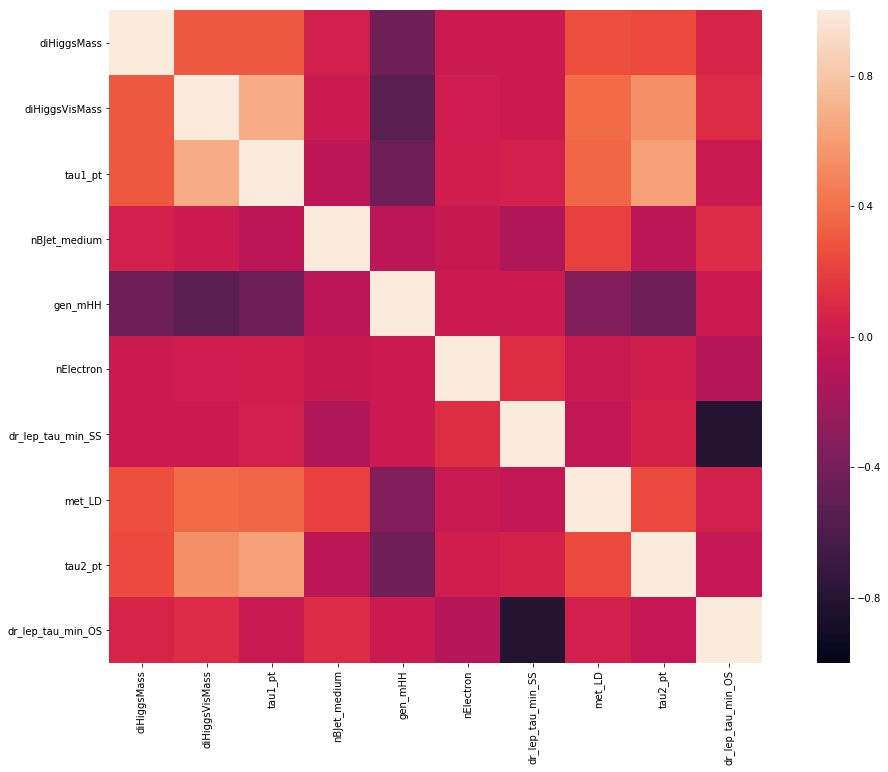

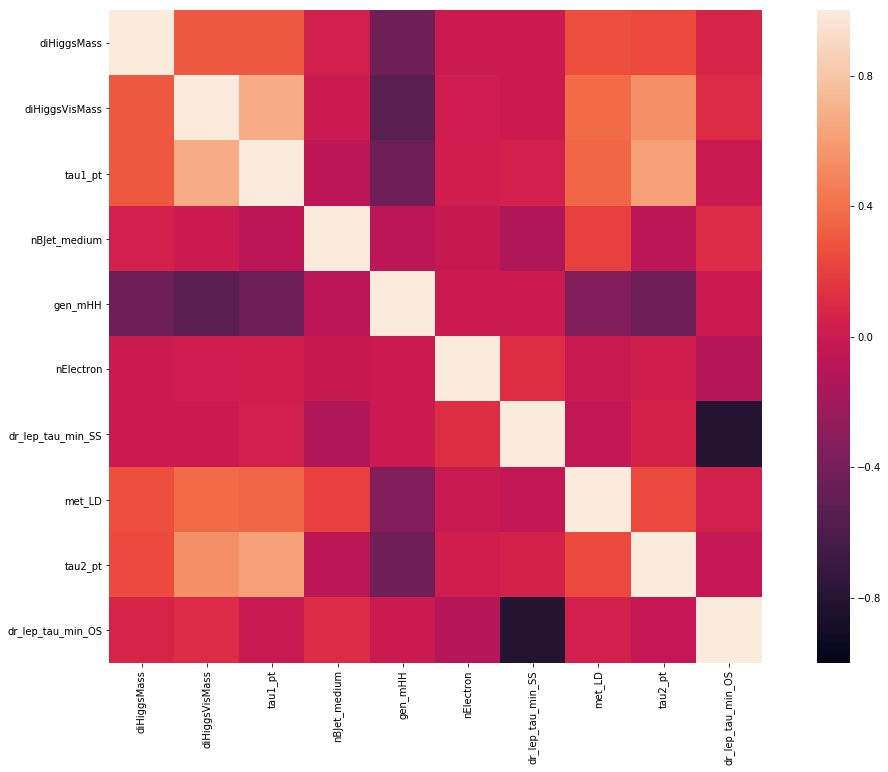

In [37]:
for target in [0,1] :
    corr_mat = data.loc[(data['target']==0), features].astype(float).corr() #
    fig, ax = plt.subplots(figsize=(20, 12)) 
    seaborn.heatmap(corr_mat, square=True, ax=ax, vmin=-1., vmax=1.)
    if(target == 0) : filename4="{}/Signal_Correl_{}.pdf".format(channel, hyppar)
    else: filename4="{}/Background_Correl_{}.pdf".format(channel, hyppar)   
    plt.savefig(filename4);